## 0. Setup

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 100
from IPython.display import display
import os
import warnings
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
import glob

plt.rcParams.update(plt.rcParamsDefault)
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
plt.rcParams.update(new_rc_params)

sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42

#Given fold changes (x = ATAC, y = RNA),
#a list of percentile boundaries, 
#and a color list, return colors for points
def fraction_colors(x, y, percentiles, colorlist):
    
    #Unpacks the color list
    #This tells you what each color slot means
    HAHE = colorlist[0]
    HAME = colorlist[1]
    MAHE = colorlist[2]
    MAME = colorlist[3]
    NONE = colorlist[4]
    
    #Unpacks the percentiles list
    #This tells you what each threshold value in the list means
    HA_threshold = percentiles[0]
    MA_threshold = percentiles[1]
    HE_threshold = percentiles[2]
    ME_threshold = percentiles[3]
    
    x_high = np.percentile(x, HA_threshold)
    x_low = np.percentile(x, MA_threshold)
    y_high = np.percentile(y, HE_threshold)
    y_low = np.percentile(y, ME_threshold)
    
    colors = [None] * len(x)
    for j in np.arange(len(x)):
        if x[j] > x_high:
            if y[j] > y_high:
                colors[j] = HAHE
            elif y[j] < y_low:
                colors[j] = HAME
            else:
                colors[j] = NONE
        elif x[j] < x_low:
            if y[j] > y_high:
                colors[j] = MAHE
            elif y[j] < y_low:
                colors[j] = MAME
            else:
                colors[j] = NONE
        else:
            colors[j] = NONE
    return colors

## 1. Load files and filter based on accessibility vs. expression

In [3]:
peaktypes_nearestgeneloc = '~/Labwork/Bioinformatics/Transcripts/' + 'Sall_peaktypes_nearestgene.gff'
genes_TMMexprloc = '~/Labwork/Bioinformatics/Parhyale_RNA-Seq/SLURM_scripts/' + 'kallisto.gene.TMM.EXPR.matrix'
Omni_multicov_mikadoloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/OmniATAC_bothruns_peaks/' + 'OmniATAC_bothruns_multicov_unformat_mikado.tsv'
Omni_multicov_norm_mikadoloc = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/OmniATAC_bothruns_peaks/' + 'OmniATAC_bothruns_multicov_mfuzz_mikado_standardised.tsv'

peaktypes_nearestgene = pd.DataFrame(pd.read_csv(peaktypes_nearestgeneloc, sep = '\t', header = None))
peaktypes_nearestgene['newstart'] = peaktypes_nearestgene[3] - 1
peaktypes_nearestgene['contig_start_end'] = peaktypes_nearestgene[0].astype(str) + '_' + peaktypes_nearestgene['newstart'].astype('str') + '_' + peaktypes_nearestgene[4].astype('str')

stages = ['S13', 'S19', 'S21', 'S23']

genes_TMMexpr = pd.DataFrame(pd.read_csv(genes_TMMexprloc, sep = '\t'))
genes_TMMexpr.columns = ['gene', 'S13A', 'S13B', 'S13C', 'S19A', 'S19B', 'S19C', 'S21A', 'S21B', 'S21C', 'S23A', 'S23B', 'S23C']

for stage in stages:
    stage_cols = [col for col in genes_TMMexpr.columns if stage in col]
    genes_TMMexpr[stage + '_mean_expr'] = genes_TMMexpr[stage_cols].mean(axis = 1)

Omni_multicov_mikado = pd.DataFrame(pd.read_csv(Omni_multicov_mikadoloc, sep = '\t'))

for stage in stages:
    stage_cols = [col for col in Omni_multicov_mikado.columns if stage in col]
    Omni_multicov_mikado[stage + '_mean_acc'] = Omni_multicov_mikado[stage_cols].mean(axis = 1)

peaks_withvalues = Omni_multicov_mikado[['GENE.ID'] + [col for col in Omni_multicov_mikado.columns if 'mean' in col]].merge(peaktypes_nearestgene[['contig_start_end', 1, 9]], left_on = 'GENE.ID', right_on = 'contig_start_end')
peaks_withvalues = peaks_withvalues[peaks_withvalues[9] != 'None.None.None']
peaks_withall = peaks_withvalues.merge(genes_TMMexpr[['gene'] + [col for col in genes_TMMexpr.columns if 'mean' in col]], left_on = 9, right_on = 'gene')
peaks_withall['expr_total'] = peaks_withall[[col for col in peaks_withall.columns if 'mean_expr' in str(col)]].sum(axis = 'columns')
peaks_nozero = peaks_withall[peaks_withall['expr_total'] != 0]

display(peaks_withvalues)
display(peaks_withall)
display(peaks_nozero)

GENE.ID  S13_mean_acc  S19_mean_acc  \
1            phaw_50.000009_11628_11888          45.0         39.00   
2          phaw_50.000014_206406_207519         641.0        256.50   
3          phaw_50.000014_238984_239410         100.5         17.50   
4          phaw_50.000014_239711_240244         159.0        167.50   
5            phaw_50.000019_87818_88035         119.0         54.25   
...                                 ...           ...           ...   
181405  phaw_50.283875b_1496273_1496592          55.0         16.75   
181406  phaw_50.283875b_1535466_1535680          34.0         28.25   
181407  phaw_50.283875b_1546841_1547714         208.0        224.75   
181408         phaw_50.283876_1905_3313        1290.5        547.00   
181409       phaw_50.283876_24624_25204         586.0        241.50   

        S21_mean_acc  S23_mean_acc                 contig_start_end  \
1               32.0          29.0       phaw_50.000009_11628_11888   
2              195.5         118.5     phaw_50.000014_206406_207519   
3               78.5          11.0     phaw_50.000014_238984_239410   
4               71.0         126.5     phaw_50.000014_239711_240244   
5               53.5           7.5       phaw_50.000019_87818_88035   
...              ...           ...                              ...   
181405          19.5          35.5  phaw_50.283875b_1496273_1496592   
181406          19.0          37.5  phaw_50.283875b_1535466_1535680   
181407         596.5         372.5  phaw_50.283875b_1546841_1547714   
181408         324.5         330.0         phaw_50.283876_1905_3313   
181409         173.0         157.5       phaw_50.283876_24624_25204   

                          1                          9  
1       proximal_intergenic    mikado.phaw_50.000009G1  
2       proximal_intergenic    mikado.phaw_50.000014G4  
3         distal_intergenic    mikado.phaw_50.000014G4  
4         distal_intergenic    mikado.phaw_50.000014G4  
5         distal_intergenic    mikado.phaw_50.000019G1  
...                     ...                        ...  
181405  proximal_intergenic  mikado.phaw_50.283875bG12  
181406    distal_intergenic  mikado.phaw_50.283875bG13  
181407    distal_intergenic  mikado.phaw_50.283875bG13  
181408             promoter    mikado.phaw_50.283876G1  
181409    distal_intergenic    mikado.phaw_50.283876G1  

[148723 rows x 8 columns]

GENE.ID  S13_mean_acc  S19_mean_acc  \
0            phaw_50.000009_11628_11888          45.0         39.00   
1          phaw_50.000014_206406_207519         641.0        256.50   
2          phaw_50.000014_238984_239410         100.5         17.50   
3          phaw_50.000014_239711_240244         159.0        167.50   
4            phaw_50.000019_87818_88035         119.0         54.25   
...                                 ...           ...           ...   
148718  phaw_50.283875b_1496273_1496592          55.0         16.75   
148719  phaw_50.283875b_1535466_1535680          34.0         28.25   
148720  phaw_50.283875b_1546841_1547714         208.0        224.75   
148721         phaw_50.283876_1905_3313        1290.5        547.00   
148722       phaw_50.283876_24624_25204         586.0        241.50   

        S21_mean_acc  S23_mean_acc                 contig_start_end  \
0               32.0          29.0       phaw_50.000009_11628_11888   
1              195.5         118.5     phaw_50.000014_206406_207519   
2               78.5          11.0     phaw_50.000014_238984_239410   
3               71.0         126.5     phaw_50.000014_239711_240244   
4               53.5           7.5       phaw_50.000019_87818_88035   
...              ...           ...                              ...   
148718          19.5          35.5  phaw_50.283875b_1496273_1496592   
148719          19.0          37.5  phaw_50.283875b_1535466_1535680   
148720         596.5         372.5  phaw_50.283875b_1546841_1547714   
148721         324.5         330.0         phaw_50.283876_1905_3313   
148722         173.0         157.5       phaw_50.283876_24624_25204   

                          1                          9  \
0       proximal_intergenic    mikado.phaw_50.000009G1   
1       proximal_intergenic    mikado.phaw_50.000014G4   
2         distal_intergenic    mikado.phaw_50.000014G4   
3         distal_intergenic    mikado.phaw_50.000014G4   
4         distal_intergenic    mikado.phaw_50.000019G1   
...                     ...                        ...   
148718  proximal_intergenic  mikado.phaw_50.283875bG12   
148719    distal_intergenic  mikado.phaw_50.283875bG13   
148720    distal_intergenic  mikado.phaw_50.283875bG13   
148721             promoter    mikado.phaw_50.283876G1   
148722    distal_intergenic    mikado.phaw_50.283876G1   

                             gene  S13_mean_expr  S19_mean_expr  \
0         mikado.phaw_50.000009G1       5.652333       5.892333   
1         mikado.phaw_50.000014G4       0.000000       0.000000   
2         mikado.phaw_50.000014G4       0.000000       0.000000   
3         mikado.phaw_50.000014G4       0.000000       0.000000   
4         mikado.phaw_50.000019G1       0.081333       0.036000   
...                           ...            ...            ...   
148718  mikado.phaw_50.283875bG12      10.126333       9.234667   
148719  mikado.phaw_50.283875bG13       0.750667       0.000000   
148720  mikado.phaw_50.283875bG13       0.750667       0.000000   
148721    mikado.phaw_50.283876G1       0.162000       0.289333   
148722    mikado.phaw_50.283876G1       0.162000       0.289333   

        S21_mean_expr  S23_mean_expr  expr_total  
0            7.430667       8.842667   27.818000  
1            0.000000       0.000000    0.000000  
2            0.000000       0.000000    0.000000  
3            0.000000       0.000000    0.000000  
4            0.061333       0.631000    0.809667  
...               ...            ...         ...  
148718       3.469000       7.225000   30.055000  
148719       0.000000       1.364667    2.115333  
148720       0.000000       1.364667    2.115333  
148721       1.178000       1.426000    3.055333  
148722       1.178000       1.426000    3.055333  

[148723 rows x 14 columns]

GENE.ID  S13_mean_acc  S19_mean_acc  \
0            phaw_50.000009_11628_11888          45.0         39.00   
4            phaw_50.000019_87818_88035         119.0         54.25   
5            phaw_50.000019_97413_97613         267.0        127.75   
6                  phaw_50.000023_4_138          33.0         41.25   
7            phaw_50.000023_12095_12730         218.0        107.75   
...                                 ...           ...           ...   
148718  phaw_50.283875b_1496273_1496592          55.0         16.75   
148719  phaw_50.283875b_1535466_1535680          34.0         28.25   
148720  phaw_50.283875b_1546841_1547714         208.0        224.75   
148721         phaw_50.283876_1905_3313        1290.5        547.00   
148722       phaw_50.283876_24624_25204         586.0        241.50   

        S21_mean_acc  S23_mean_acc                 contig_start_end  \
0               32.0          29.0       phaw_50.000009_11628_11888   
4               53.5           7.5       phaw_50.000019_87818_88035   
5               69.5          96.0       phaw_50.000019_97413_97613   
6              196.0          68.0             phaw_50.000023_4_138   
7               73.0          78.0       phaw_50.000023_12095_12730   
...              ...           ...                              ...   
148718          19.5          35.5  phaw_50.283875b_1496273_1496592   
148719          19.0          37.5  phaw_50.283875b_1535466_1535680   
148720         596.5         372.5  phaw_50.283875b_1546841_1547714   
148721         324.5         330.0         phaw_50.283876_1905_3313   
148722         173.0         157.5       phaw_50.283876_24624_25204   

                          1                          9  \
0       proximal_intergenic    mikado.phaw_50.000009G1   
4         distal_intergenic    mikado.phaw_50.000019G1   
5         distal_intergenic    mikado.phaw_50.000019G1   
6         distal_intergenic    mikado.phaw_50.000023G2   
7       proximal_intergenic    mikado.phaw_50.000023G2   
...                     ...                        ...   
148718  proximal_intergenic  mikado.phaw_50.283875bG12   
148719    distal_intergenic  mikado.phaw_50.283875bG13   
148720    distal_intergenic  mikado.phaw_50.283875bG13   
148721             promoter    mikado.phaw_50.283876G1   
148722    distal_intergenic    mikado.phaw_50.283876G1   

                             gene  S13_mean_expr  S19_mean_expr  \
0         mikado.phaw_50.000009G1       5.652333       5.892333   
4         mikado.phaw_50.000019G1       0.081333       0.036000   
5         mikado.phaw_50.000019G1       0.081333       0.036000   
6         mikado.phaw_50.000023G2       0.000000       0.000000   
7         mikado.phaw_50.000023G2       0.000000       0.000000   
...                           ...            ...            ...   
148718  mikado.phaw_50.283875bG12      10.126333       9.234667   
148719  mikado.phaw_50.283875bG13       0.750667       0.000000   
148720  mikado.phaw_50.283875bG13       0.750667       0.000000   
148721    mikado.phaw_50.283876G1       0.162000       0.289333   
148722    mikado.phaw_50.283876G1       0.162000       0.289333   

        S21_mean_expr  S23_mean_expr  expr_total  
0            7.430667       8.842667   27.818000  
4            0.061333       0.631000    0.809667  
5            0.061333       0.631000    0.809667  
6            0.000000       0.340333    0.340333  
7            0.000000       0.340333    0.340333  
...               ...            ...         ...  
148718       3.469000       7.225000   30.055000  
148719       0.000000       1.364667    2.115333  
148720       0.000000       1.364667    2.115333  
148721       1.178000       1.426000    3.055333  
148722       1.178000       1.426000    3.055333  

[146274 rows x 14 columns]

## 2. Make plots for accessibility vs. expression for all peaks

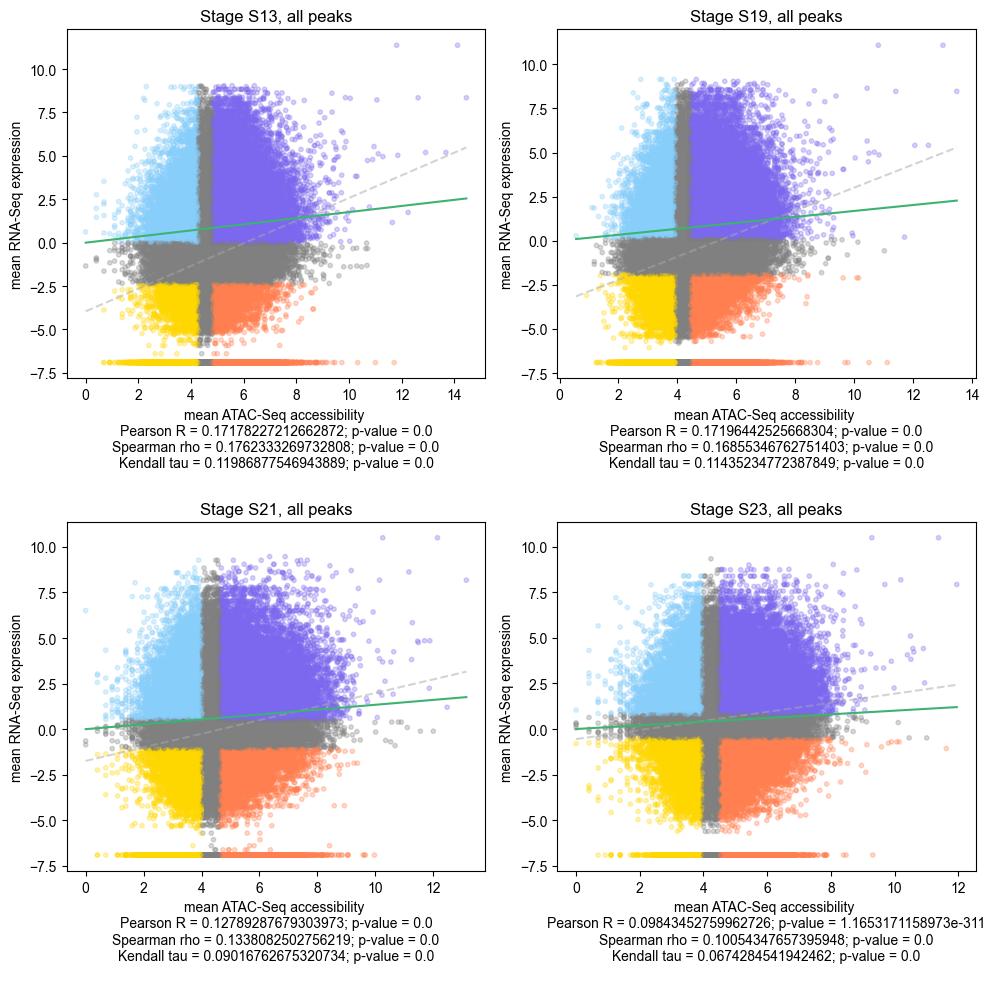

In [94]:
plt.figure(figsize = (10, 10))
i = 1
for stage in stages:
    x, y = np.log(peaks_nozero[stage + '_mean_acc'].values + 0.001), np.log(peaks_nozero[stage + '_mean_expr'].values + 0.001)
    pearson, pearson_p = scipy.stats.pearsonr(x, y)
    spearman, spearman_p = scipy.stats.spearmanr(x, y)
    kendall, kendall_p = scipy.stats.kendalltau(x, y)
    m, b = np.polyfit(x, y, 1)
    
    percentiles = [50, 25, 50, 25]
    colorlist = ['mediumslateblue', 'coral', 'lightskyblue', 'gold', 'gray']
    colors = fraction_colors(x, y, percentiles, colorlist)
    
    plt.subplot(2, 2, i)
    plt.scatter(x = x, y = y, color = colors, alpha = 0.3, s = 10)
    
    xrange = np.linspace(min(x), max(x), 500)
    plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
    plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
    
    plt.title('Stage ' + stage + ', all peaks')
    plt.ylabel('mean RNA-Seq expression')
    plt.xlabel('mean ATAC-Seq accessibility \n' + 
               'Pearson R = ' + str(pearson) + '; p-value = ' + str(pearson_p) + '\n' +
               'Spearman rho = ' + str(spearman) + '; p-value = ' + str(spearman_p) + '\n' +
               'Kendall tau = ' + str(kendall) + '; p-value = ' + str(kendall_p) + '\n'
              )
    i += 1
    
plt.tight_layout()
plt.show()

## 3. Make plots for accessibility vs. expression for only promoter peaks

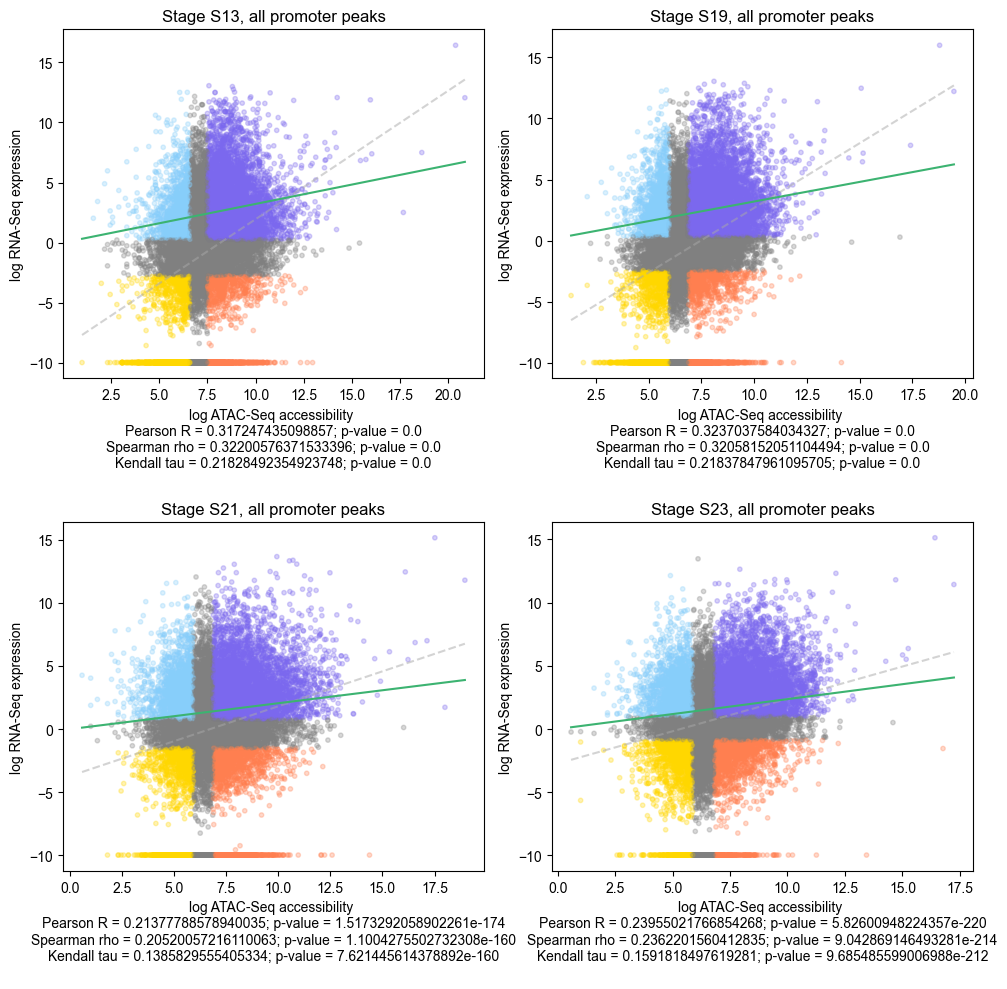

In [95]:
promoters_nozero = peaks_nozero[peaks_nozero[1] == 'promoter']

paired_dict = {}

plt.figure(figsize = (10, 10))
i = 1
for stage in stages:
    x, y = np.log2(promoters_nozero[stage + '_mean_acc'].values + 0.001), np.log2(promoters_nozero[stage + '_mean_expr'].values + 0.001)
    pearson, pearson_p = scipy.stats.pearsonr(x, y)
    spearman, spearman_p = scipy.stats.spearmanr(x, y)
    kendall, kendall_p = scipy.stats.kendalltau(x, y)
    m, b = np.polyfit(x, y, 1)
    
    percentiles = [50, 25, 50, 25]
    colorlist = ['mediumslateblue', 'coral', 'lightskyblue', 'gold', 'gray']
    colors = fraction_colors(x, y, percentiles, colorlist)
    
    plt.subplot(2, 2, i)
    plt.scatter(x = x, y = y, color = colors, alpha = 0.3, s = 10)
    
    xrange = np.linspace(min(x), max(x), 500)
    plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
    plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
    
    plt.title('Stage ' + stage + ', all promoter peaks')

    plt.ylabel('log RNA-Seq expression')
    plt.xlabel('log ATAC-Seq accessibility \n' + 
               'Pearson R = ' + str(pearson) + '; p-value = ' + str(pearson_p) + '\n' +
               'Spearman rho = ' + str(spearman) + '; p-value = ' + str(spearman_p) + '\n' + 
               'Kendall tau = ' + str(kendall) + '; p-value = ' + str(kendall_p) + '\n'
              )
    i += 1
    
plt.tight_layout()
plt.show()

## 4. Make neater plots for accessibility vs. expression for all non-zero peaks

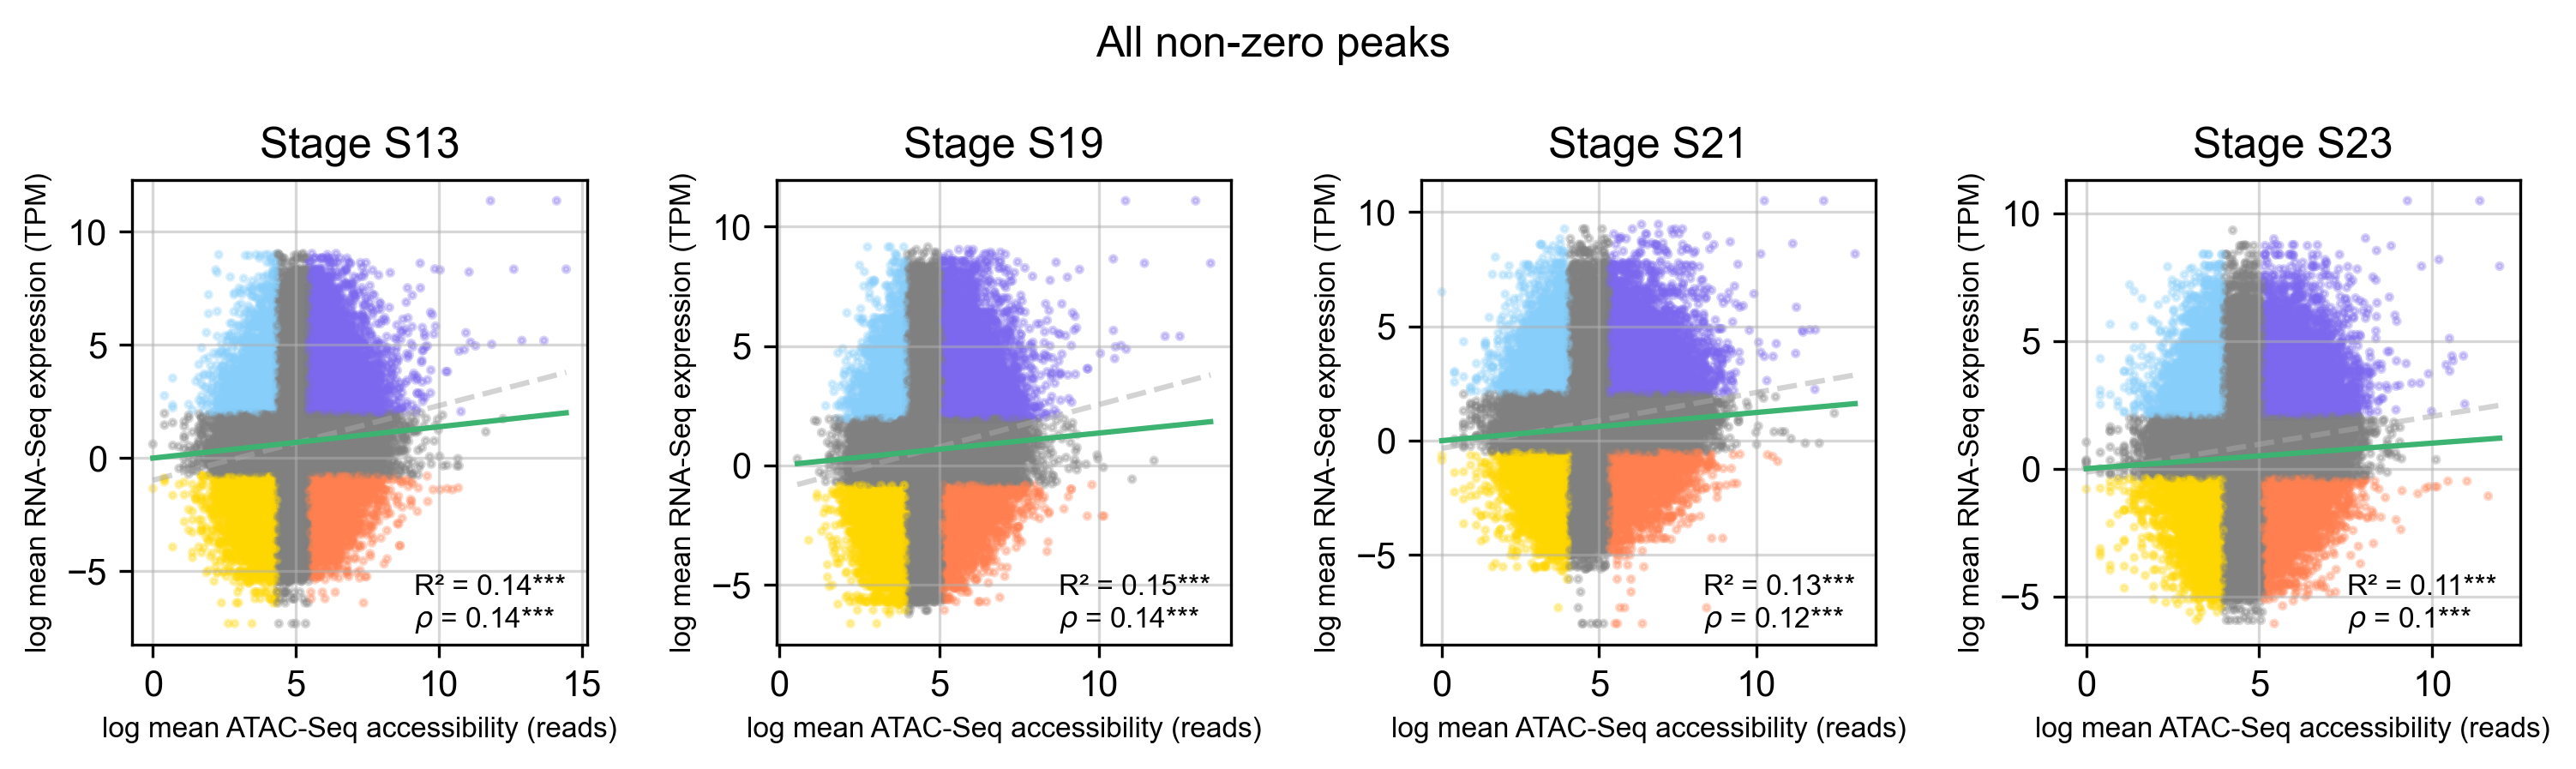

In [21]:
plt.figure(figsize = (10, 3), dpi=300)
i = 1

dummy_container = {}

for stage in stages:
    stages_df = peaks_nozero[[stage + '_mean_acc', stage + '_mean_expr', 'gene', 'contig_start_end']]
    stages_filtered = stages_df[(stages_df[stage + '_mean_acc'] != 0) & (stages_df[stage + '_mean_expr'] != 0)]
    x, y = np.log(stages_filtered[stage + '_mean_acc'].values), np.log(stages_filtered[stage + '_mean_expr'].values)
    dummy_container[stage] = pd.DataFrame({stage + '_mean_acc': x,
                                           stage + '_mean_expr': y,
                                           'gene': stages_filtered['gene'],
                                           'contig_start_end': stages_filtered['contig_start_end']})
    pearson, pearson_p = scipy.stats.pearsonr(x, y)
    spearman, spearman_p = scipy.stats.spearmanr(x, y)
    kendall, kendall_p = scipy.stats.kendalltau(x, y)
    m, b = np.polyfit(x, y, 1)
    
    percentiles = [75, 25, 75, 25]
    colorlist = ['mediumslateblue', 'coral', 'lightskyblue', 'gold', 'gray']
    colors = fraction_colors(x, y, percentiles, colorlist)
    dummy_container[stage]['colors'] = colors
    
    plt.subplot(1, 4, i)
    plt.grid(True, alpha = 0.5)
    plt.scatter(x = x, y = y, color = colors, alpha = 0.3, s = 3, rasterized = True)
    
    xrange = np.linspace(min(x), max(x), 500)
    plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
    plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
    
    plt.title('Stage ' + stage)
    plt.ylabel('log mean RNA-Seq expression (TPM)', fontsize = 8)
    plt.xlabel('log mean ATAC-Seq accessibility (reads)', fontsize = 8)
    
    pearson_siglabel = '***' if pearson_p < 0.001 else ''
    spearman_siglabel = '***' if spearman_p < 0.001 else ''
    textstr = 'R\u00b2 = ' + str(np.round(pearson, 2)) + pearson_siglabel + '\n' + '$\\rho$ = ' + str(np.round(spearman, 2)) + pearson_siglabel
    ax = plt.gca()
    plt.text(0.62, 0.02, textstr, fontsize=8, verticalalignment='bottom', transform = ax.transAxes)
    
    i += 1

plt.suptitle('All non-zero peaks')
plt.tight_layout()
plt.savefig('Omni_vs_RNA_stagespecific_allpeak_scatters.pdf')
plt.show()

## 5. Generate lists of nearby genes for peaks in each colored region from (4)

__SPECIAL USAGE NOTE__
1. You should run section (15) first to populate the all_list variable.
2. Then, run the cell above (3) to populate the variables used for getting lists.
3. Finally, run this cell to actually convert and save the lists into the directory specified.

In [22]:
#make sure to run cells below to make the all_list variable first!

OmnivsRNAlistdir = 'OmnivsRNAlists/all_peaks/'

!mkdir {OmnivsRNAlistdir}

for stage in dummy_container:
    df = dummy_container[stage]
    df = df.merge(all_list, left_on = 'gene', right_on = 'mikado_gene', how = 'left')
    
    colors_list_dict = {}
    
    colors_list_dict['HAHE'] = df[df['colors'] == 'mediumslateblue']['UNIPROT_ID'].unique()
    colors_list_dict['HAME'] = df[df['colors'] == 'coral']['UNIPROT_ID'].unique()
    colors_list_dict['MAHE'] = df[df['colors'] == 'lightskyblue']['UNIPROT_ID'].unique()
    colors_list_dict['MAME'] = df[df['colors'] == 'gold']['UNIPROT_ID'].unique()
    
    for lst in colors_list_dict:
        with open(OmnivsRNAlistdir + 'OmnivsRNA_' + str(stage) + '_' + lst + '_allpeaks.txt', 'w+') as outfile:
            for item in colors_list_dict[lst]:
                if str(item) == 'nan':
                    continue
                else:
                    outfile.write(str(item) + '\n')

mkdir: OmnivsRNAlists/all_peaks/: File exists


## 6. Make neater plots for accessibility vs. expression for all non-zero promoter peaks

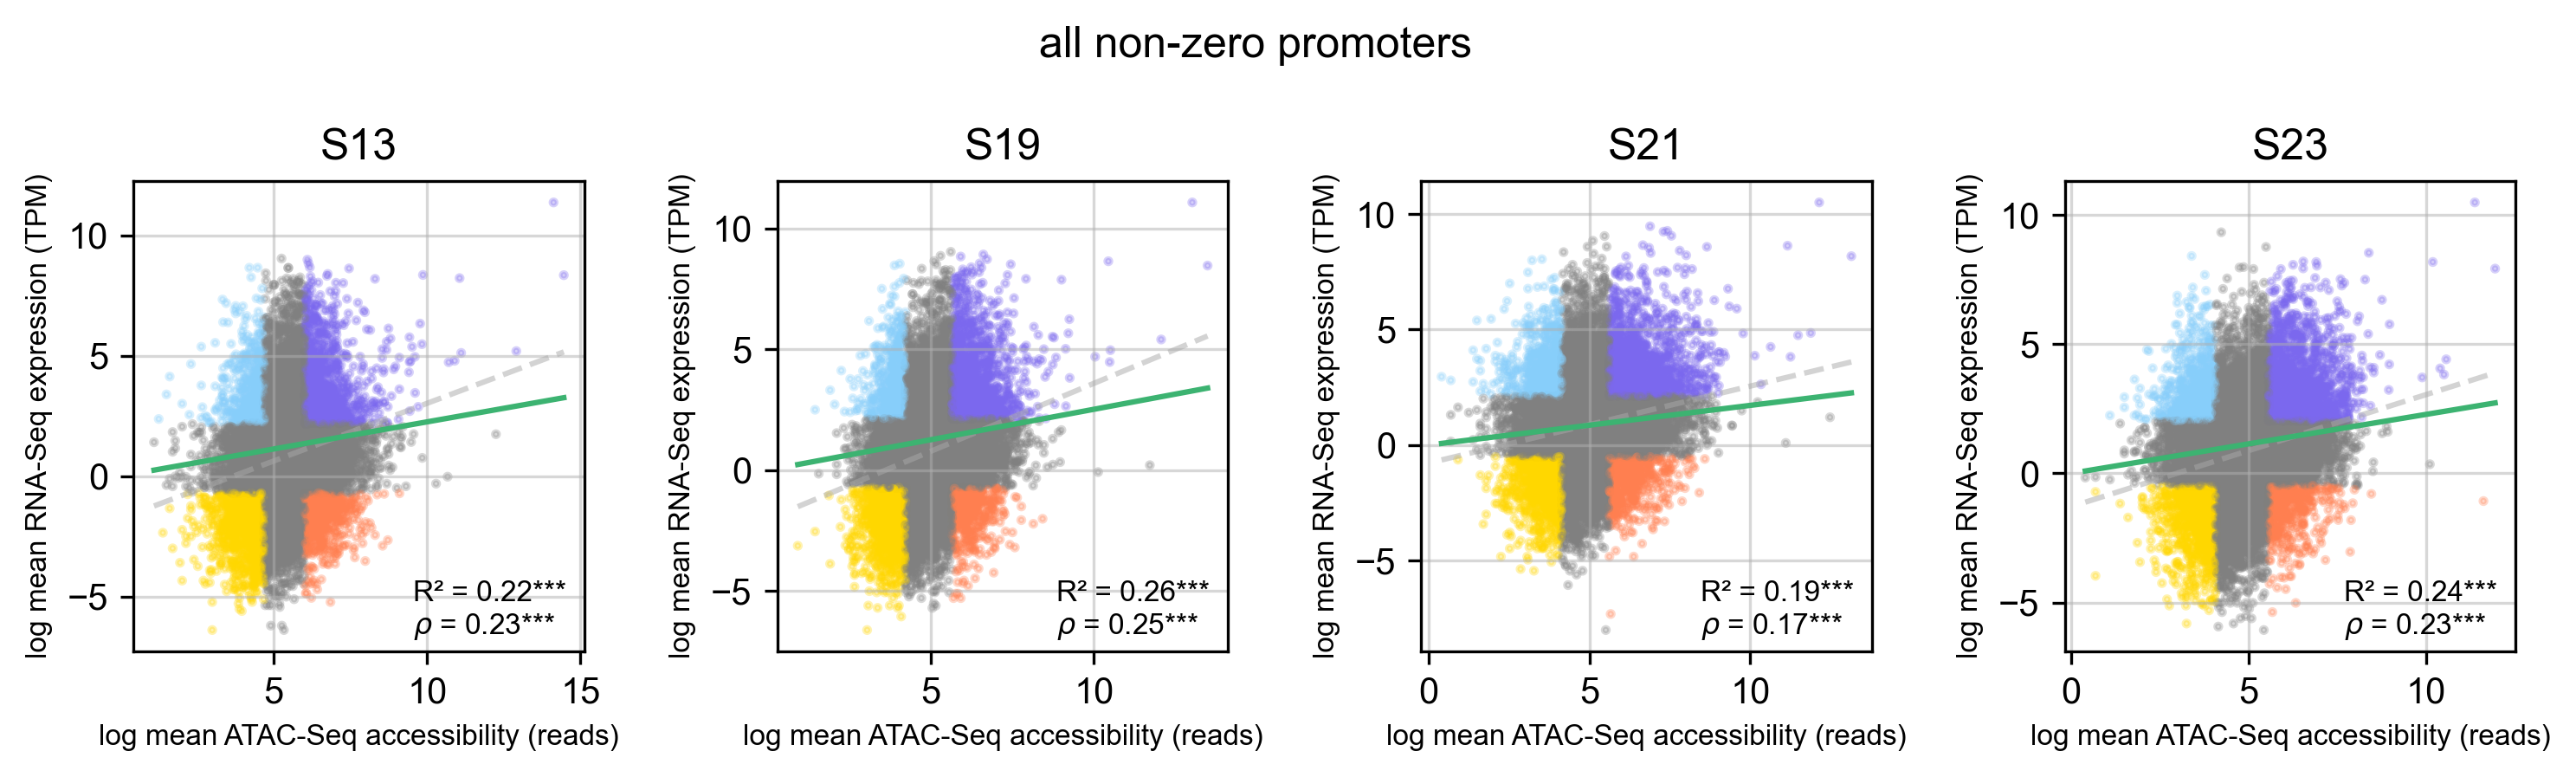

In [23]:
promoters_nozero = peaks_nozero[peaks_nozero[1] == 'promoter']

dummy_container = {}

plt.figure(figsize = (10, 3), dpi=300)
i = 1
for stage in stages:
    stages_df = promoters_nozero[[stage + '_mean_acc', stage + '_mean_expr', 'gene', 'contig_start_end']]
    stages_filtered = stages_df[(stages_df[stage + '_mean_acc'] != 0) & (stages_df[stage + '_mean_expr'] != 0)]
    x, y = np.log(stages_filtered[stage + '_mean_acc'].values), np.log(stages_filtered[stage + '_mean_expr'].values)
    dummy_container[stage] = pd.DataFrame({stage + '_mean_acc': x,
                                           stage + '_mean_expr': y,
                                           'gene': stages_filtered['gene'],
                                           'contig_start_end': stages_filtered['contig_start_end']})
    
    pearson, pearson_p = scipy.stats.pearsonr(x, y)
    spearman, spearman_p = scipy.stats.spearmanr(x, y)
    kendall, kendall_p = scipy.stats.kendalltau(x, y)
    m, b = np.polyfit(x, y, 1)
    
    percentiles = [75, 25, 75, 25]
    colorlist = ['mediumslateblue', 'coral', 'lightskyblue', 'gold', 'gray']
    colors = fraction_colors(x, y, percentiles, colorlist)
    dummy_container[stage]['colors'] = colors
    
    plt.subplot(1, 4, i)
    plt.grid(True, alpha = 0.5)
    plt.scatter(x = x, y = y, color = colors, alpha = 0.3, s = 3, rasterized = True)
    
    xrange = np.linspace(min(x), max(x), 500)
    plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
    plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
    
    plt.title(stage)
    plt.ylabel('log mean RNA-Seq expression (TPM)', fontsize = 8)
    plt.xlabel('log mean ATAC-Seq accessibility (reads)', fontsize = 8)
    
    pearson_siglabel = '***' if pearson_p < 0.001 else ''
    spearman_siglabel = '***' if spearman_p < 0.001 else ''
    textstr = 'R\u00b2 = ' + str(np.round(pearson, 2)) + pearson_siglabel + '\n' + '$\\rho$ = ' + str(np.round(spearman, 2)) + pearson_siglabel
    ax = plt.gca()
    plt.text(0.62, 0.02, textstr, fontsize=8, verticalalignment='bottom', transform = ax.transAxes)
    
    i += 1

plt.suptitle('all non-zero promoters')
plt.tight_layout()
plt.savefig('Omni_vs_RNA_stagespecific_propeak_scatters.pdf')
plt.show()

## 7. Generate lists of nearby genes for peaks in each colored region from (6)

__SPECIAL USAGE NOTE__
1. You should run section (15) first to populate the all_list variable.
2. Then, run the cell above (6) to populate the variables used for getting lists.
3. Finally, run this cell to actually convert and save the lists into the directory specified.

In [ ]:
#make sure to run cells below to make the all_list variable first!

OmnivsRNAlistdir = 'OmnivsRNAlists/promoters/'

!mkdir {OmnivsRNAlistdir}

for stage in dummy_container:
    df = dummy_container[stage]
    df = df.merge(all_list, left_on = 'gene', right_on = 'mikado_gene', how = 'left')
    
    colors_list_dict = {}
    
    colors_list_dict['HAHE'] = df[df['colors'] == 'mediumslateblue']['UNIPROT_ID'].unique()
    colors_list_dict['HAME'] = df[df['colors'] == 'coral']['UNIPROT_ID'].unique()
    colors_list_dict['MAHE'] = df[df['colors'] == 'lightskyblue']['UNIPROT_ID'].unique()
    colors_list_dict['MAME'] = df[df['colors'] == 'gold']['UNIPROT_ID'].unique()
    
    for lst in colors_list_dict:
        with open(OmnivsRNAlistdir + 'OmnivsRNA_' + str(stage) + '_' + lst + '_promoters.txt', 'w+') as outfile:
            for item in colors_list_dict[lst]:
                if str(item) == 'nan':
                    continue
                else:
                    outfile.write(str(item) + '\n')

## 8. Extract fold change comparisons from files and merge accessibility and expression into a single dataframe

In [5]:
comparisons = ['S19_vs_S13', 'S21_vs_S19', 'S23_vs_S21']

compfolder = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/OmnivsRNA/'
peaktypes_nearestgene = pd.DataFrame(pd.read_csv(peaktypes_nearestgeneloc, sep = '\t', header = None))
peaktypes_nearestgene['newstart'] = peaktypes_nearestgene[3] - 1
peaktypes_nearestgene['contig_start_end'] = peaktypes_nearestgene[0].astype(str) + '_' + peaktypes_nearestgene['newstart'].astype('str') + '_' + peaktypes_nearestgene[4].astype('str')

hard_Mfuzz_dir = '/Users/dennis/Labwork/Bioinformatics/Omni-ATAC-Seq/Mfuzz_mikado/'
acores = 9
mvalue = 1.1
name_generator_3 = hard_Mfuzz_dir + 'Mfuzz_a**_m*_*_clusters.tsv'.replace('**', str(acores)).replace('*_*', str(mvalue))

mfuzz_cmeans = pd.DataFrame(pd.read_csv(name_generator_3))
mfuzz_cmeans_val = mfuzz_cmeans.filter(regex=("cluster.*"))
mfuzz_cmeans['best_cluster'] = mfuzz_cmeans_val.idxmax(axis = 1).str.split('.', expand = True)[1].astype(int)
mfuzz_cmeans['topval'] = mfuzz_cmeans_val.max(axis = 1)

display(mfuzz_cmeans)

comparisondfs = {}
significantdfs = {}
versusclusters = {}
versussigclusters = {}

for comparison in comparisons:
    RNAdfloc = compfolder + comparison + '_RNASeq_results.csv'
    RNAdf = pd.DataFrame(pd.read_csv(RNAdfloc))
    Omnidfloc = compfolder + comparison + '_OmniATACSeq_results.csv'
    Omnidf = pd.DataFrame(pd.read_csv(Omnidfloc))
    
    df1 = Omnidf.merge(peaktypes_nearestgene[['contig_start_end', 1, 9]], left_on = 'Unnamed: 0', right_on = 'contig_start_end')
    df2 = df1.merge(RNAdf[['Unnamed: 0', 'log2FoldChange', 'padj']], left_on = 9, right_on = 'Unnamed: 0')
    df2.dropna(inplace = True)
    
    significant = df2[(df2['padj_x'] <= 0.05) & (df2['padj_y'] <= 0.05)]
    withcluster = df2.merge(mfuzz_cmeans[['gene.id', 'best_cluster']], left_on = 'Unnamed: 0_x', right_on = 'gene.id')
    withcluster_sig = significant.merge(mfuzz_cmeans[['gene.id', 'best_cluster']], left_on = 'Unnamed: 0_x', right_on = 'gene.id')
    
    comparisondfs[comparison] = df2
    significantdfs[comparison] = significant
    versusclusters[comparison] = withcluster
    versussigclusters[comparison] = withcluster_sig

Unnamed: 0                          gene.id  \
0              phaw_50.000003_4302_5642         phaw_50.000003_4302_5642   
1            phaw_50.000009_11628_11888       phaw_50.000009_11628_11888   
2          phaw_50.000014_206406_207519     phaw_50.000014_206406_207519   
3          phaw_50.000014_238984_239410     phaw_50.000014_238984_239410   
4          phaw_50.000014_239711_240244     phaw_50.000014_239711_240244   
...                                 ...                              ...   
181405  phaw_50.283875b_1496273_1496592  phaw_50.283875b_1496273_1496592   
181406  phaw_50.283875b_1535466_1535680  phaw_50.283875b_1535466_1535680   
181407  phaw_50.283875b_1546841_1547714  phaw_50.283875b_1546841_1547714   
181408         phaw_50.283876_1905_3313         phaw_50.283876_1905_3313   
181409       phaw_50.283876_24624_25204       phaw_50.283876_24624_25204   

                         gene.names     cluster.1     cluster.2     cluster.3  \
0                                 .  1.489119e-10  1.658498e-12  3.066869e-13   
1         mikado.phaw_50.000009G1.1  2.249265e-01  6.136322e-03  6.524058e-04   
2         mikado.phaw_50.000014G4.1  1.985215e-12  9.815418e-17  7.367725e-17   
3         mikado.phaw_50.000014G4.1  7.220162e-02  2.265438e-04  9.599721e-04   
4         mikado.phaw_50.000014G4.1  2.040459e-03  5.007315e-04  3.314377e-04   
...                             ...           ...           ...           ...   
181405  mikado.phaw_50.283875bG12.1  4.187937e-07  9.996280e-01  5.678566e-07   
181406  mikado.phaw_50.283875bG13.1  2.192718e-10  9.998430e-01  3.131999e-08   
181407  mikado.phaw_50.283875bG13.1  3.398675e-11  5.127871e-10  9.999977e-01   
181408    mikado.phaw_50.283876G1.1  4.286039e-13  8.145032e-17  2.537475e-17   
181409    mikado.phaw_50.283876G1.1  7.772391e-12  4.468029e-16  2.738735e-16   

           cluster.4     cluster.5     cluster.6     cluster.7     cluster.8  \
0       2.851760e-07  7.152653e-07  9.999548e-01  3.510698e-12  4.314979e-12   
1       3.272255e-01  1.256240e-01  1.449655e-01  3.360334e-03  1.367315e-03   
2       9.331935e-13  4.650654e-10  9.999604e-01  1.299604e-16  3.779018e-15   
3       1.344768e-02  5.659657e-01  1.325753e-01  1.524165e-04  4.607045e-02   
4       4.409588e-01  3.050751e-01  2.142652e-01  4.040285e-03  1.280701e-03   
...              ...           ...           ...           ...           ...   
181405  9.111347e-05  8.583512e-08  2.423140e-07  2.794642e-04  2.243153e-08   
181406  3.756821e-06  6.621292e-10  2.528074e-10  1.532040e-04  3.785229e-10   
181407  1.945234e-10  4.921034e-11  3.710168e-13  5.971324e-07  1.735587e-06   
181408  9.091705e-13  8.307310e-11  9.998960e-01  8.670674e-17  7.703869e-16   
181409  3.470059e-12  4.916769e-10  9.981115e-01  6.908718e-16  9.344702e-15   

           cluster.9  best_cluster    topval  
0       4.419069e-05             6  0.999955  
1       1.657422e-01             4  0.327226  
2       3.957906e-05             6  0.999960  
3       1.684002e-01             5  0.565966  
4       3.150739e-02             4  0.440959  
...              ...           ...       ...  
181405  1.202253e-07             2  0.999628  
181406  6.971840e-11             2  0.999843  
181407  2.760541e-13             3  0.999998  
181408  1.040109e-04             6  0.999896  
181409  1.888519e-03             6  0.998111  

[181410 rows x 14 columns]

## 9. Plot log fold change of accessibility and expression for all peaks

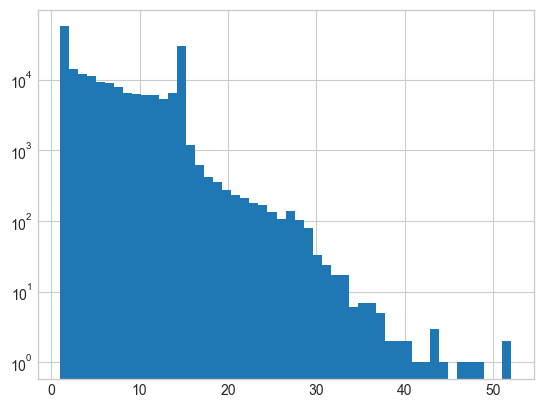

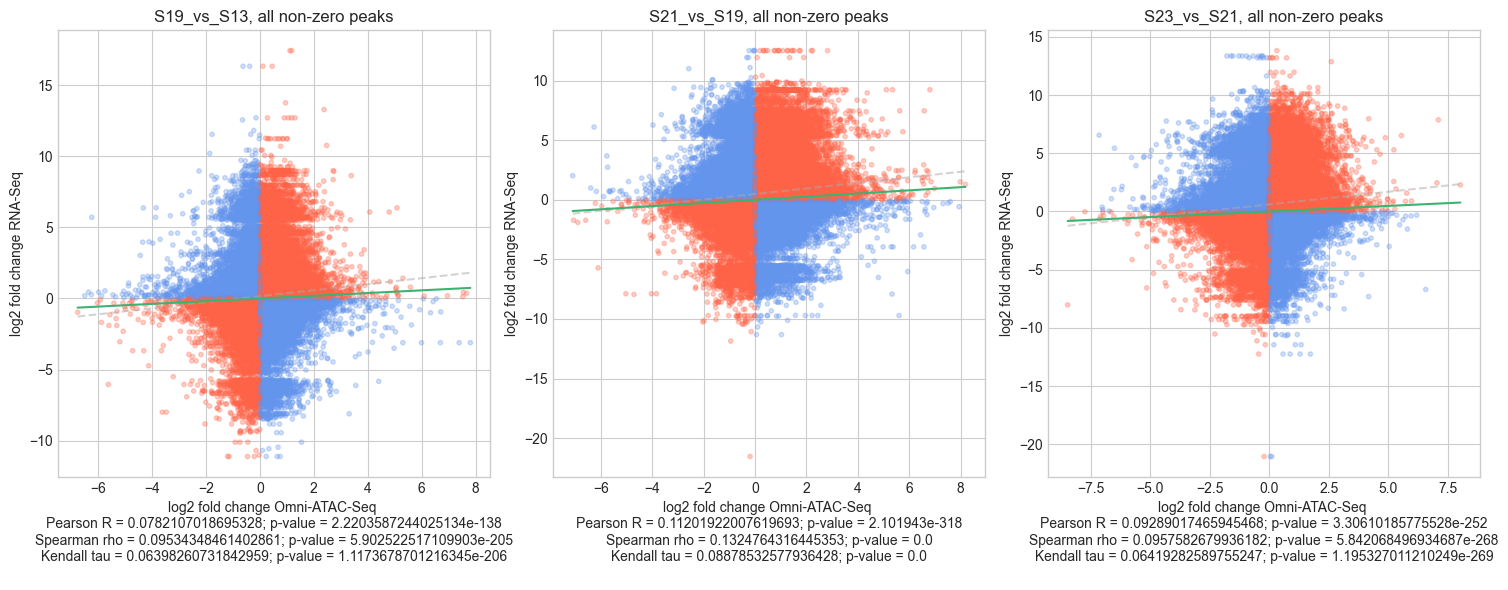

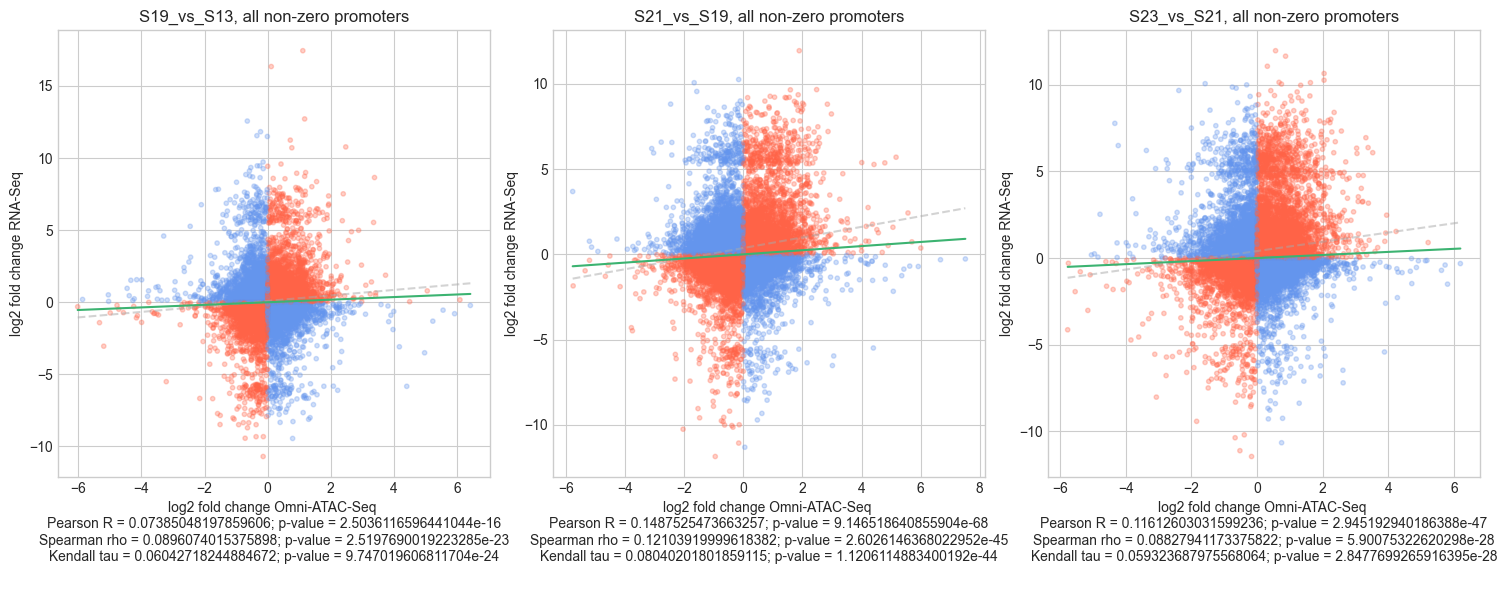

In [13]:
plt.figure(figsize = (15, 6))
i = 1
for comparison in comparisons:
    x, y = comparisondfs[comparison]['log2FoldChange_x'].values, comparisondfs[comparison]['log2FoldChange_y'].values
    pearson, pearson_p = scipy.stats.pearsonr(x, y)
    spearman, spearman_p = scipy.stats.spearmanr(x, y)
    kendall, kendall_p = scipy.stats.kendalltau(x, y)
    m, b = np.polyfit(x, y, 1)
    
    color = ['tomato' if (x[i] * y[i] > 0) else 'cornflowerblue' for i in np.arange(len(x))]
    
    xrange = np.linspace(min(x), max(x), 500)
    
    plt.subplot(1, 3, i)
    plt.scatter(x = x, y = y, color = color, alpha = 0.3, s = 10)
    plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
    plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
    plt.title(comparison + ', all non-zero peaks')
    plt.ylabel('log2 fold change RNA-Seq')
    plt.xlabel('log2 fold change Omni-ATAC-Seq \n' + 
               'Pearson R = ' + str(pearson) + '; p-value = ' + str(pearson_p) + '\n' +
               'Spearman rho = ' + str(spearman) + '; p-value = ' + str(spearman_p) + '\n' + 
               'Kendall tau = ' + str(kendall) + '; p-value = ' + str(kendall_p) + '\n'
              )
    i += 1
    
plt.tight_layout()
plt.show()


plt.figure(figsize = (15, 6))
i = 1
for comparison in comparisons:
    dummy = comparisondfs[comparison][comparisondfs[comparison][1] == 'promoter']
    x, y = dummy['log2FoldChange_x'].values, dummy['log2FoldChange_y'].values
    pearson, pearson_p = scipy.stats.pearsonr(x, y)
    spearman, spearman_p = scipy.stats.spearmanr(x, y)
    kendall, kendall_p = scipy.stats.kendalltau(x, y)
    m, b = np.polyfit(x, y, 1)
    
    color = ['tomato' if (x[i] * y[i] > 0) else 'cornflowerblue' for i in np.arange(len(x))]
    
    xrange = np.linspace(min(x), max(x), 500)
    
    plt.subplot(1, 3, i)
    plt.scatter(x = x, y = y, color = color, alpha = 0.3, s = 10)
    plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
    plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
    plt.title(comparison + ', all non-zero promoters')
    plt.ylabel('log2 fold change RNA-Seq')
    plt.xlabel('log2 fold change Omni-ATAC-Seq \n' + 
               'Pearson R = ' + str(pearson) + '; p-value = ' + str(pearson_p) + '\n' +
               'Spearman rho = ' + str(spearman) + '; p-value = ' + str(spearman_p) + '\n' + 
               'Kendall tau = ' + str(kendall) + '; p-value = ' + str(kendall_p) + '\n'
              )
    i += 1
    
plt.tight_layout()
plt.show()

## 10. Plot log fold change of accessibility and expression for all significant peaks

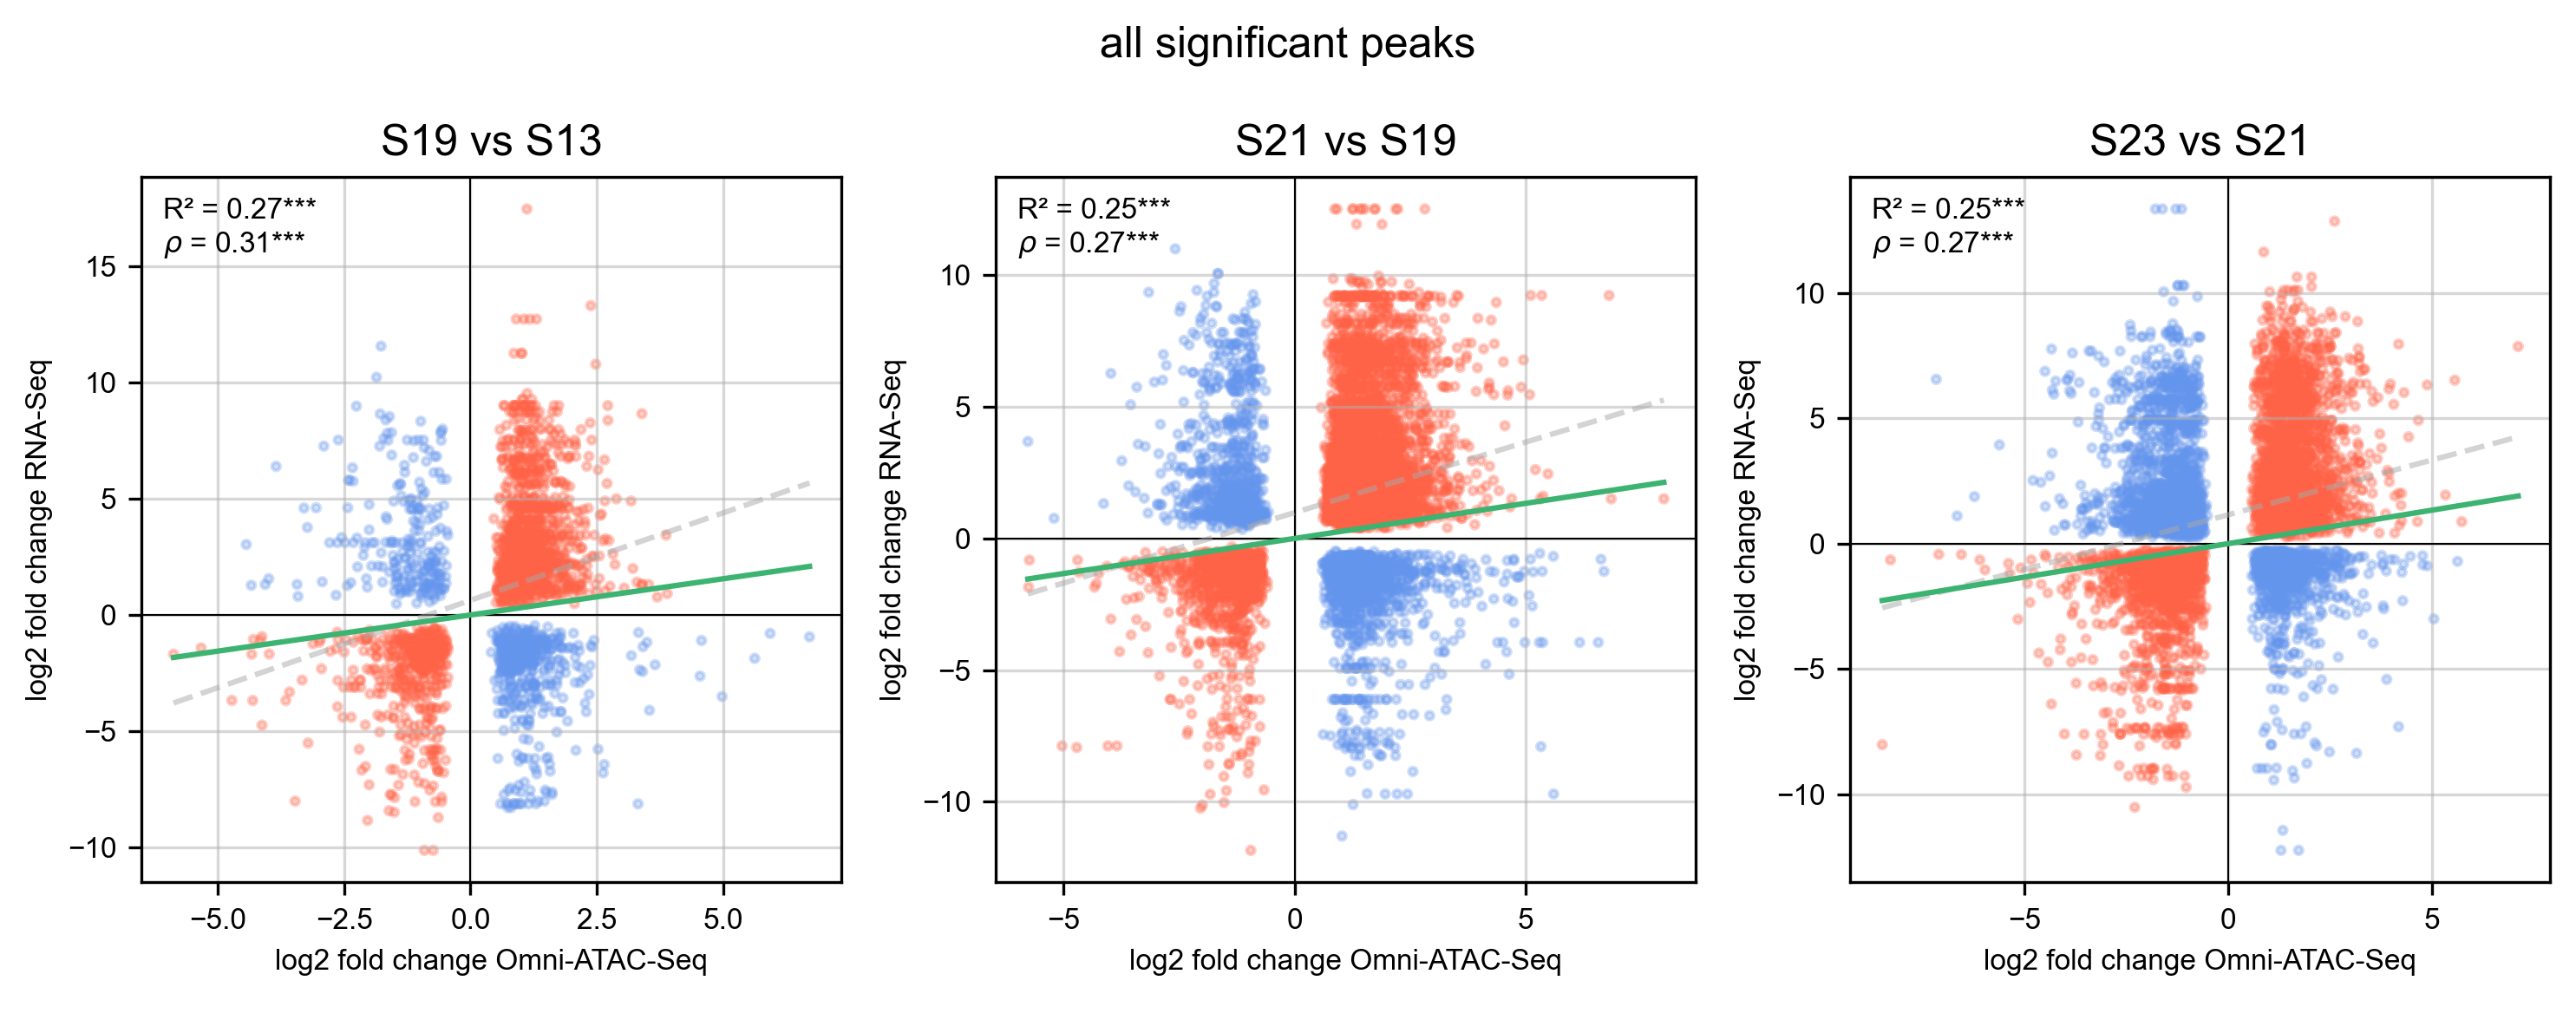

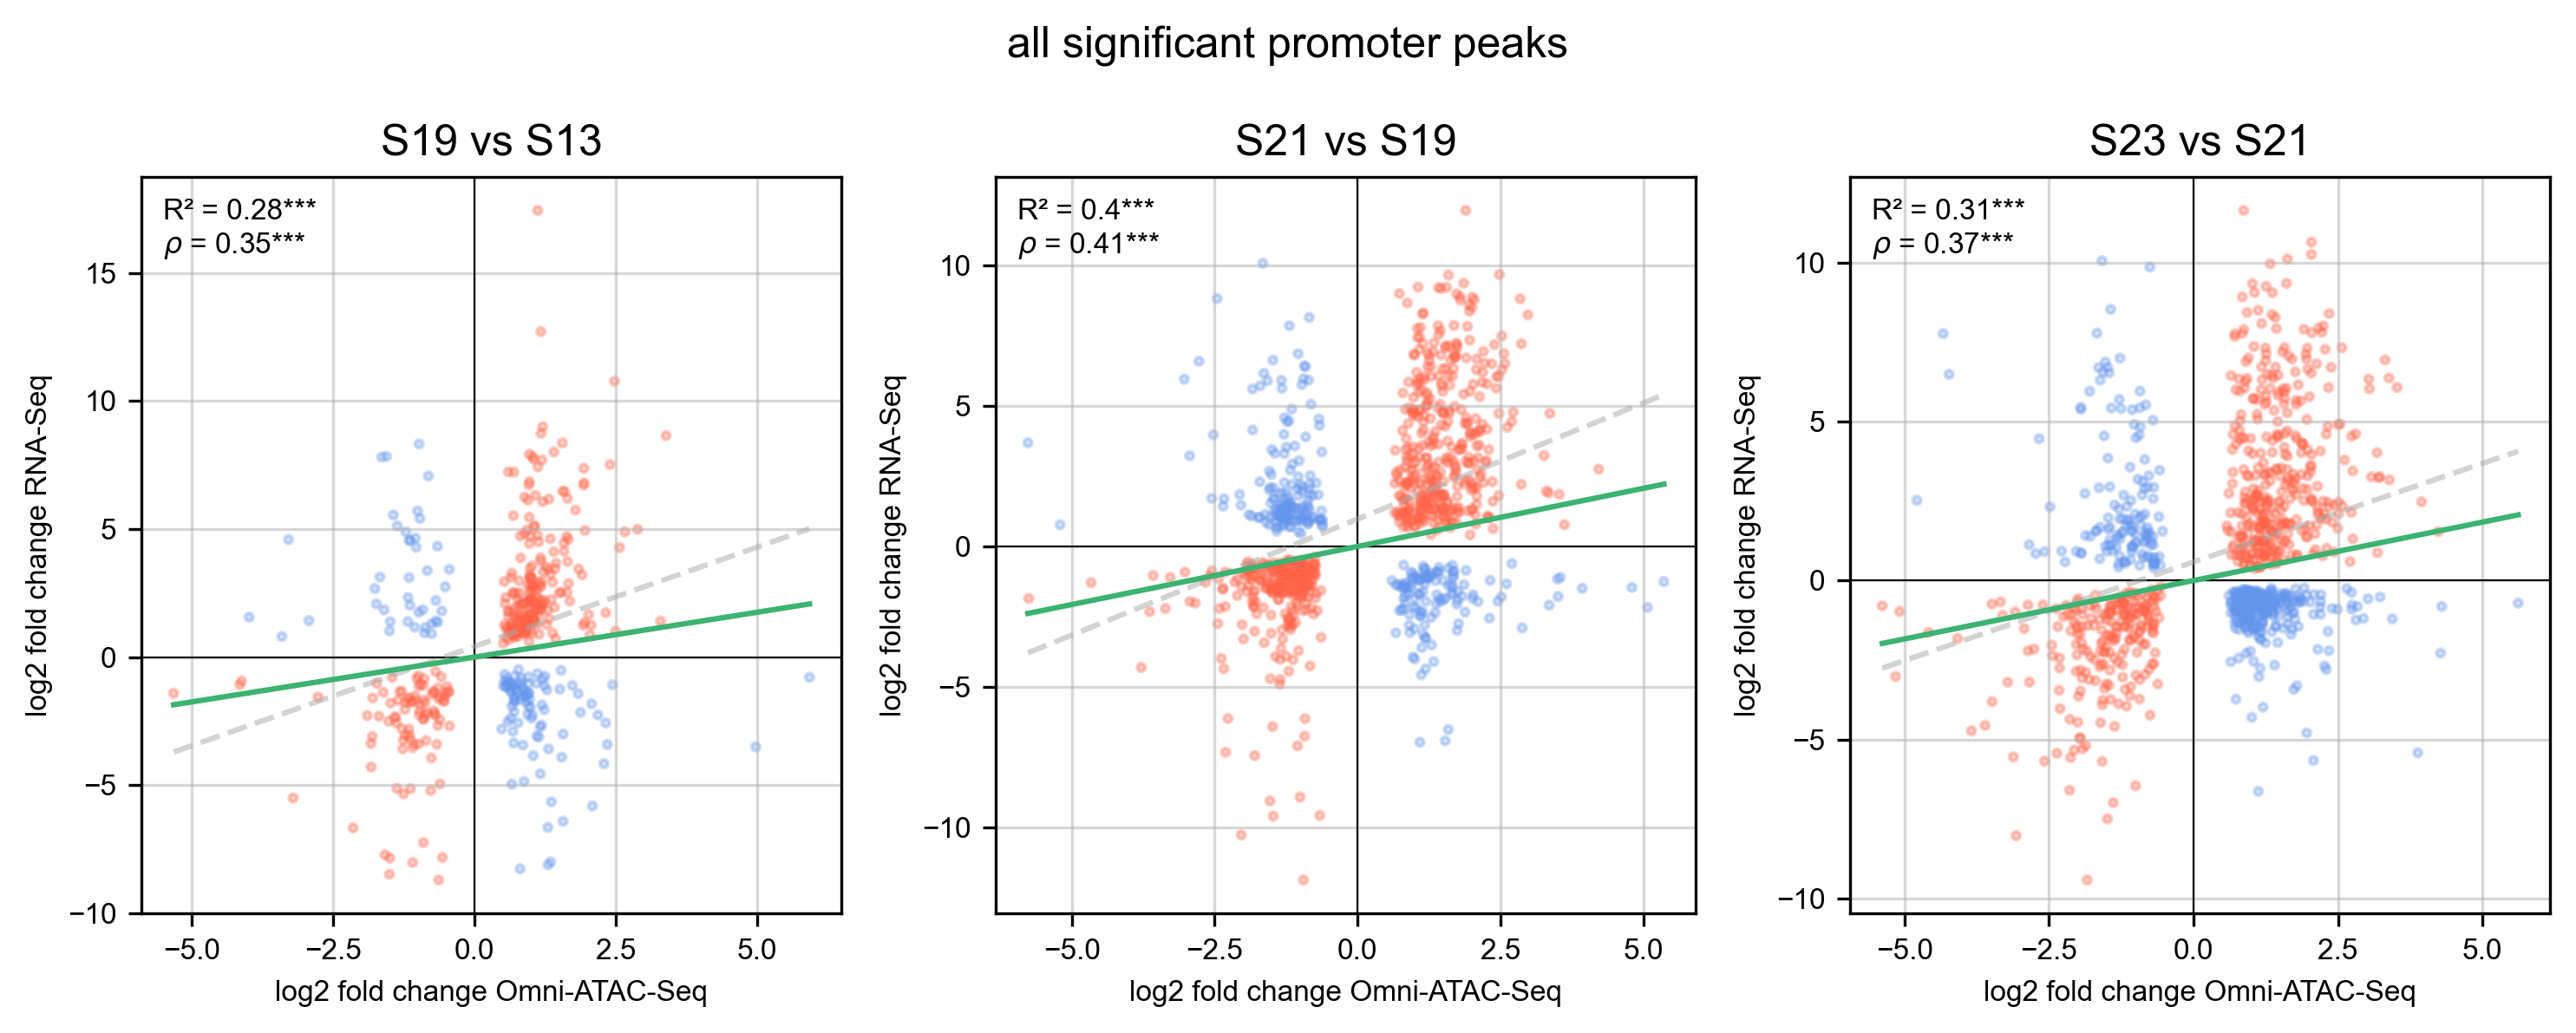

{'S19_vs_S13_allpeaks_concordant': 1888,
 'S19_vs_S13_allpeaks_disconcordant': 761,
 'S21_vs_S19_allpeaks_concordant': 5738,
 'S21_vs_S19_allpeaks_disconcordant': 2231,
 'S23_vs_S21_allpeaks_concordant': 4240,
 'S23_vs_S21_allpeaks_disconcordant': 3115,
 'S19_vs_S13_promoters_concordant': 304,
 'S19_vs_S13_promoters_disconcordant': 133,
 'S21_vs_S19_promoters_concordant': 650,
 'S21_vs_S19_promoters_disconcordant': 279,
 'S23_vs_S21_promoters_concordant': 586,
 'S23_vs_S21_promoters_disconcordant': 445}

In [12]:
plt.figure(figsize = (10, 4), dpi = 300)

comparison_matrix = {}

i = 1
for comparison in comparisons:
    x, y = significantdfs[comparison]['log2FoldChange_x'].values, significantdfs[comparison]['log2FoldChange_y'].values
    pearson, pearson_p = scipy.stats.pearsonr(x, y)
    spearman, spearman_p = scipy.stats.spearmanr(x, y)
    kendall, kendall_p = scipy.stats.kendalltau(x, y)
    m, b = np.polyfit(x, y, 1)
    
    color = ['tomato' if (x[i] * y[i] > 0) else 'cornflowerblue' for i in np.arange(len(x))]
    comparison_matrix[comparison + '_allpeaks_' + 'concordant'] = color.count('tomato')
    comparison_matrix[comparison + '_allpeaks_' + 'disconcordant'] = color.count('cornflowerblue')
    
    xrange = np.linspace(min(x), max(x), 500)
    
    plt.subplot(1, 3, i)
    plt.grid(True, alpha = 0.5)
    plt.scatter(x = x, y = y, color = color, alpha = 0.3, s = 5, rasterized = True)
    plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
    plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
    
    xlim_min, xlim_max = plt.xlim()
    ylim_min, ylim_max = plt.ylim()
    
    plt.hlines(0, xlim_min, xlim_max, color = 'black', linewidth = 0.5)
    plt.vlines(0, ylim_min, ylim_max, color = 'black', linewidth = 0.5)
    
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    
    plt.title(comparison.replace('_', ' '))
    plt.ylabel('log2 fold change RNA-Seq', fontsize = 8)
    plt.xlabel('log2 fold change Omni-ATAC-Seq\n',
               fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.xticks(fontsize = 8)
    
    pearson_siglabel = '***' if pearson_p < 0.001 else ''
    spearman_siglabel = '***' if spearman_p < 0.001 else ''
    textstr = 'R\u00b2 = ' + str(np.round(pearson, 2)) + pearson_siglabel + '\n' + '$\\rho$ = ' + str(np.round(spearman, 2)) + spearman_siglabel
    ax = plt.gca()
    plt.text(0.03, 0.97, textstr, fontsize=8, verticalalignment='top', transform = ax.transAxes)
    i += 1
    
plt.suptitle('all significant peaks')
plt.tight_layout()
plt.savefig('Omni_vs_RNA_significant_peak_LFC_plot.pdf')
plt.show()

plt.figure(figsize = (10, 4), dpi = 300)
i = 1
for comparison in comparisons:
    dummy = significantdfs[comparison][significantdfs[comparison][1] == 'promoter']
    x, y = dummy['log2FoldChange_x'].values, dummy['log2FoldChange_y'].values
    pearson, pearson_p = scipy.stats.pearsonr(x, y)
    spearman, spearman_p = scipy.stats.spearmanr(x, y)
    m, b = np.polyfit(x, y, 1)
    
    color = ['tomato' if (x[i] * y[i] > 0) else 'cornflowerblue' for i in np.arange(len(x))]
    comparison_matrix[comparison + '_promoters_' + 'concordant'] = color.count('tomato')
    comparison_matrix[comparison + '_promoters_' + 'disconcordant'] = color.count('cornflowerblue')
    
    xrange = np.linspace(min(x), max(x), 500)
    
    plt.subplot(1, 3, i)
    plt.grid(True, alpha = 0.5)
    plt.scatter(x = x, y = y, color = color, alpha = 0.3, s = 5, rasterized = True)
    plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
    plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
    
    xlim_min, xlim_max = plt.xlim()
    ylim_min, ylim_max = plt.ylim()
    
    plt.hlines(0, xlim_min, xlim_max, color = 'black', linewidth = 0.5)
    plt.vlines(0, ylim_min, ylim_max, color = 'black', linewidth = 0.5)
    
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    
    plt.title(comparison.replace('_', ' '))
    plt.ylabel('log2 fold change RNA-Seq', fontsize = 8)
    plt.xlabel('log2 fold change Omni-ATAC-Seq', fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.xticks(fontsize = 8)
    
    pearson_siglabel = '***' if pearson_p < 0.001 else ''
    spearman_siglabel = '***' if spearman_p < 0.001 else ''
    textstr = 'R\u00b2 = ' + str(np.round(pearson, 2)) + pearson_siglabel + '\n' + '$\\rho$ = ' + str(np.round(spearman, 2)) + spearman_siglabel
    ax = plt.gca()
    plt.text(0.03, 0.97, textstr, fontsize=8, verticalalignment='top', transform = ax.transAxes)
    
    i += 1

plt.suptitle('all significant promoter peaks')
plt.tight_layout()
#plt.savefig('Omni_vs_RNA_significant_pro_LFC_plot.pdf')
plt.show()

display(comparison_matrix)

## 11. Plot bar chart of number of peaks in concordant/discordant categories for all peaks

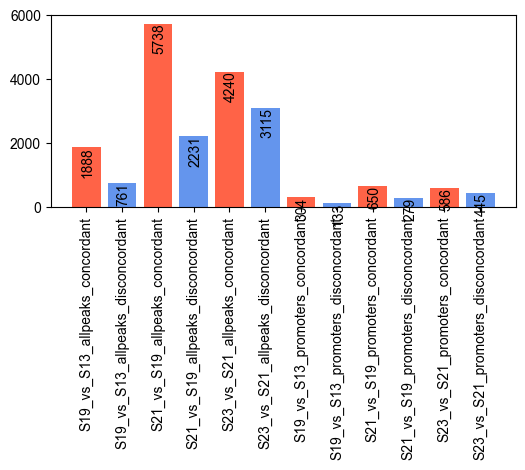

In [62]:
alternating_colors = ['tomato', 'cornflowerblue']

plt.figure(figsize = (6, 2.5))

plt.bar(x = comparison_matrix.keys(), height = comparison_matrix.values(), color = [alternating_colors[i % 2] for i in np.arange(len(comparison_matrix.keys()))])
ax = plt.gca()
for i, v in enumerate(comparison_matrix.values()):
    ax.text(i - 0.15 , v, str(v), rotation = 90, va = 'top')
plt.xticks(rotation = 90)

plt.savefig('Omni_vs_RNA_conc-vs-disc-counts.svg')

plt.show()

## 12. Plot log fold change of accessibility and expression for all peaks for each Mfuzz acore

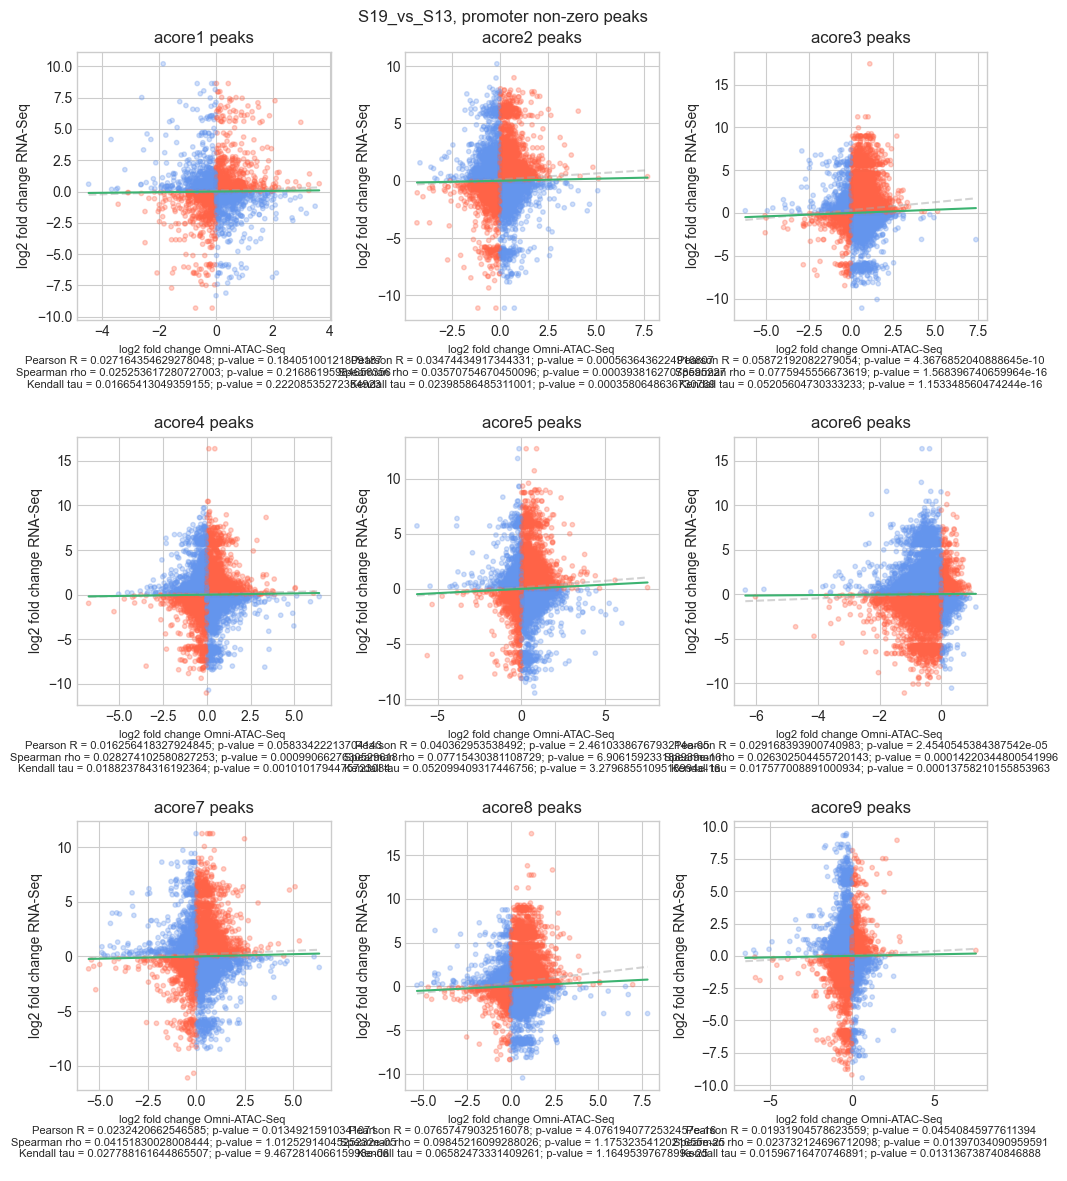

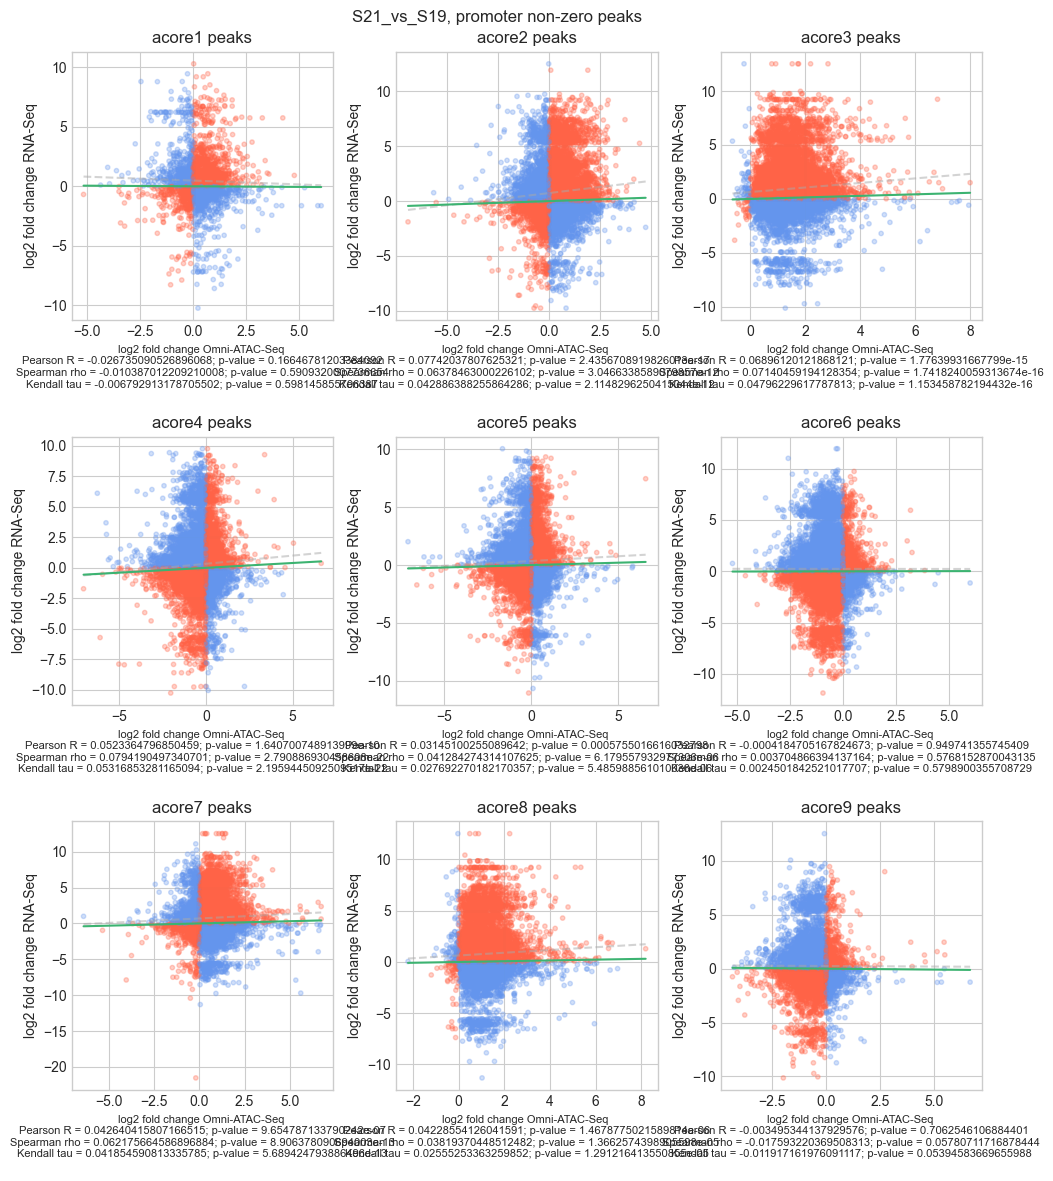

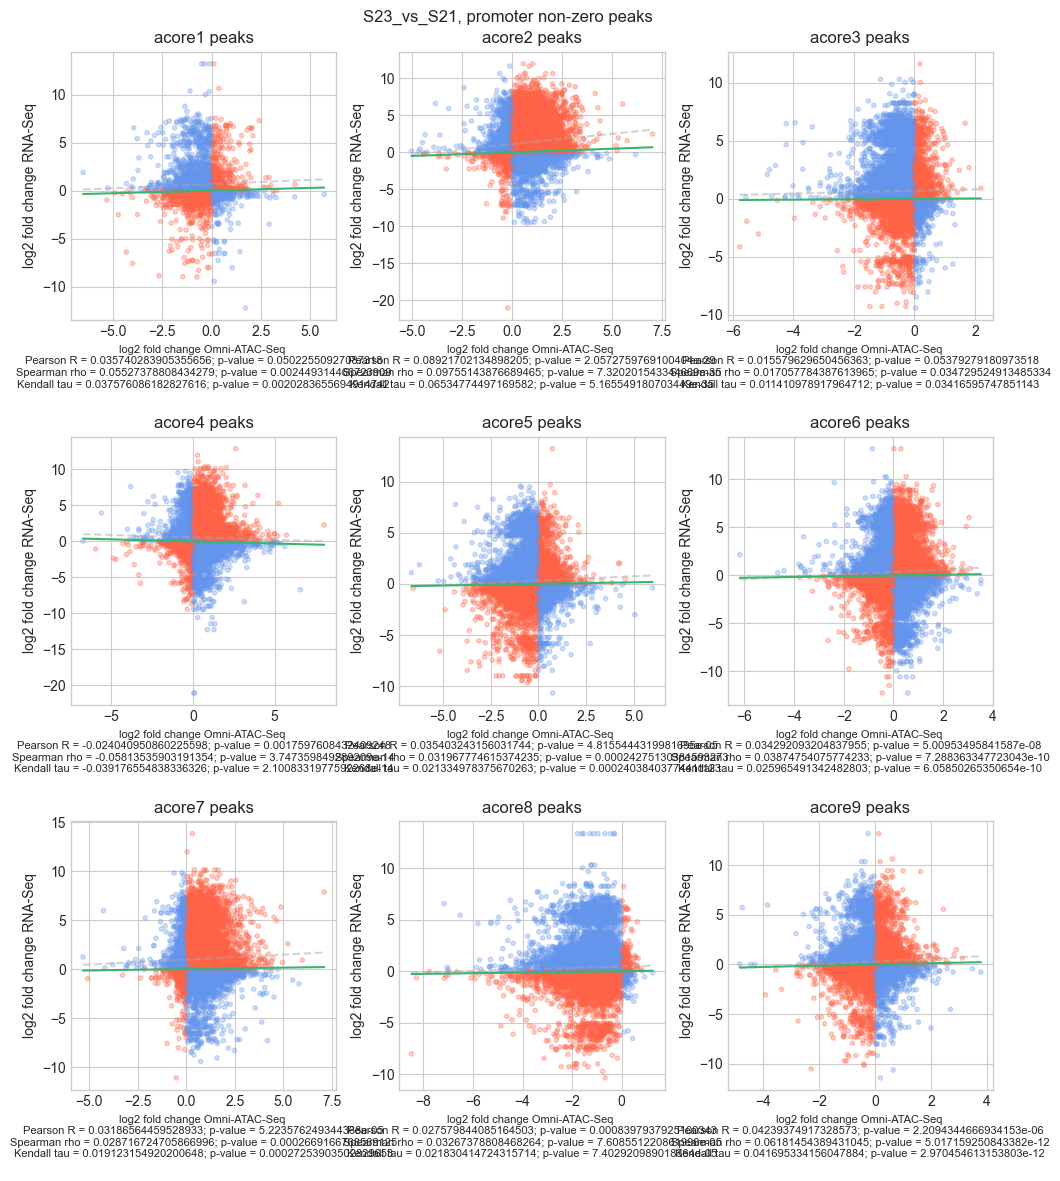

In [15]:
for comparison in versusclusters:
    
    plt.figure(figsize = (10, 12))
    plt.suptitle(comparison + ', promoter non-zero peaks')
    i = 1
    for acore in np.arange(1, acores + 1):
        dummy = versusclusters[comparison][versusclusters[comparison]['best_cluster'] == acore]
        x, y = dummy['log2FoldChange_x'].values, dummy['log2FoldChange_y'].values
        pearson, pearson_p = scipy.stats.pearsonr(x, y)
        spearman, spearman_p = scipy.stats.spearmanr(x, y)
        kendall, kendall_p = scipy.stats.kendalltau(x, y)
        m, b = np.polyfit(x, y, 1)
        
        color = ['tomato' if (x[i] * y[i] > 0) else 'cornflowerblue' for i in np.arange(len(x))]
        
        xrange = np.linspace(min(x), max(x), 500)
        
        plt.subplot(3, 3, i)
        plt.scatter(x = x, y = y, color = color, alpha = 0.3, s = 10)
        plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
        plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
        plt.title('acore' + str(acore) + ' peaks')
        plt.ylabel('log2 fold change RNA-Seq')
        plt.xlabel('log2 fold change Omni-ATAC-Seq \n' + 
               'Pearson R = ' + str(pearson) + '; p-value = ' + str(pearson_p) + '\n' +
               'Spearman rho = ' + str(spearman) + '; p-value = ' + str(spearman_p) + '\n' + 
               'Kendall tau = ' + str(kendall) + '; p-value = ' + str(kendall_p) + '\n', fontsize = 8)
        i += 1
    plt.tight_layout()
    plt.show()

## 13. Plot log fold change of accessibility and expression for significant peaks for each Mfuzz acore

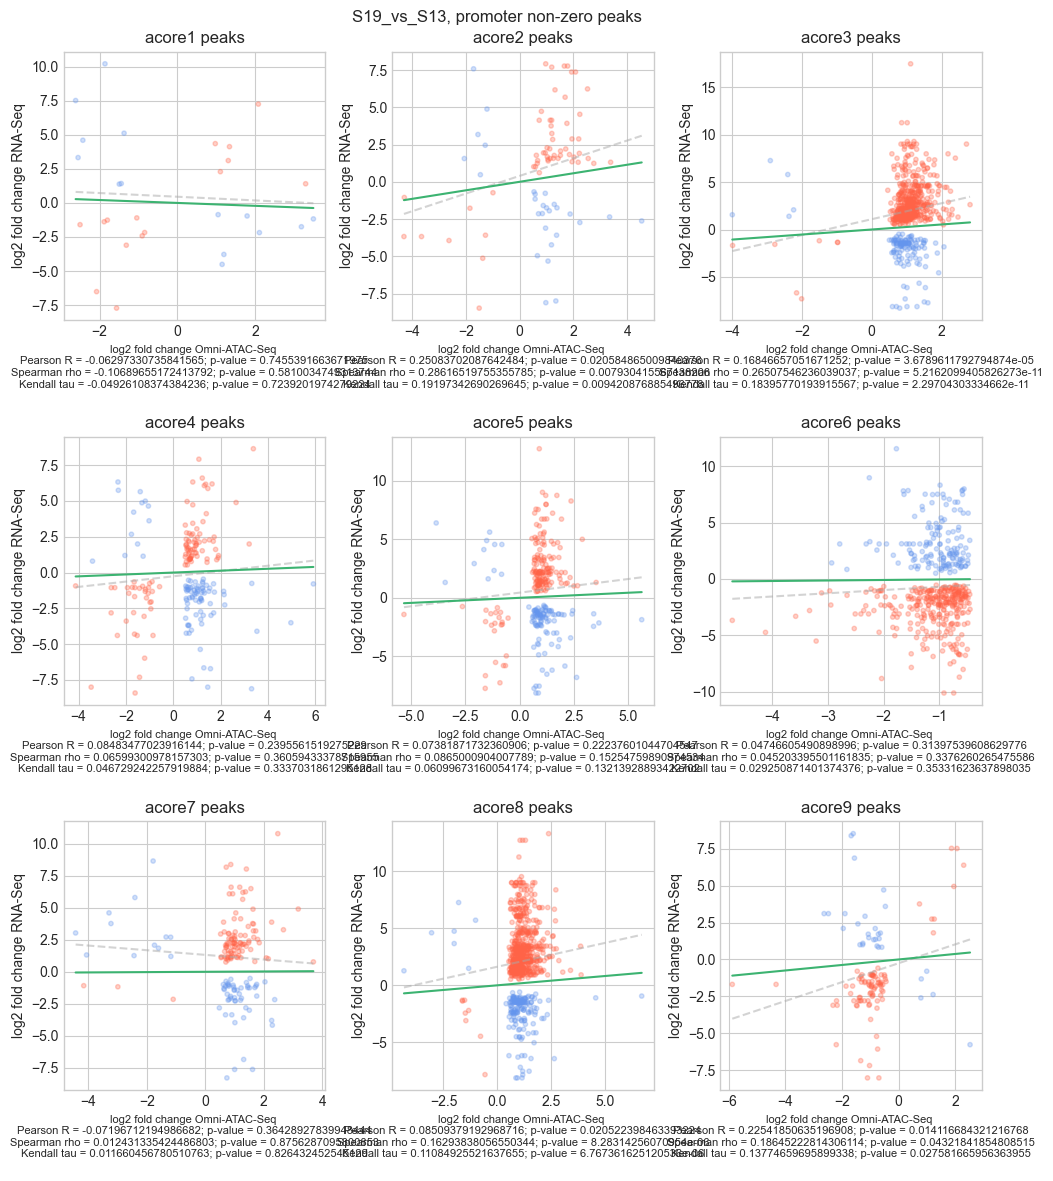

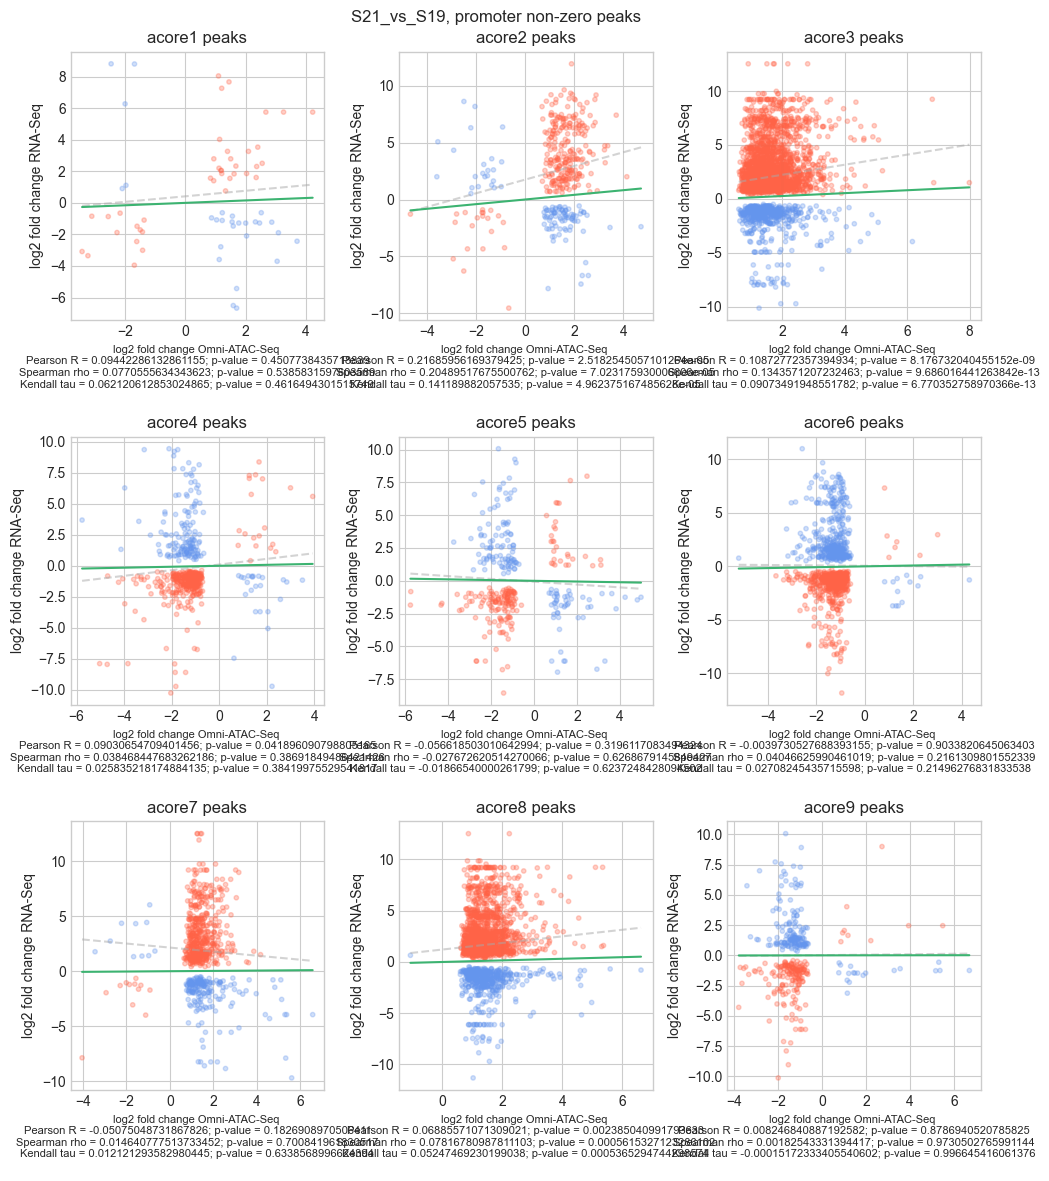

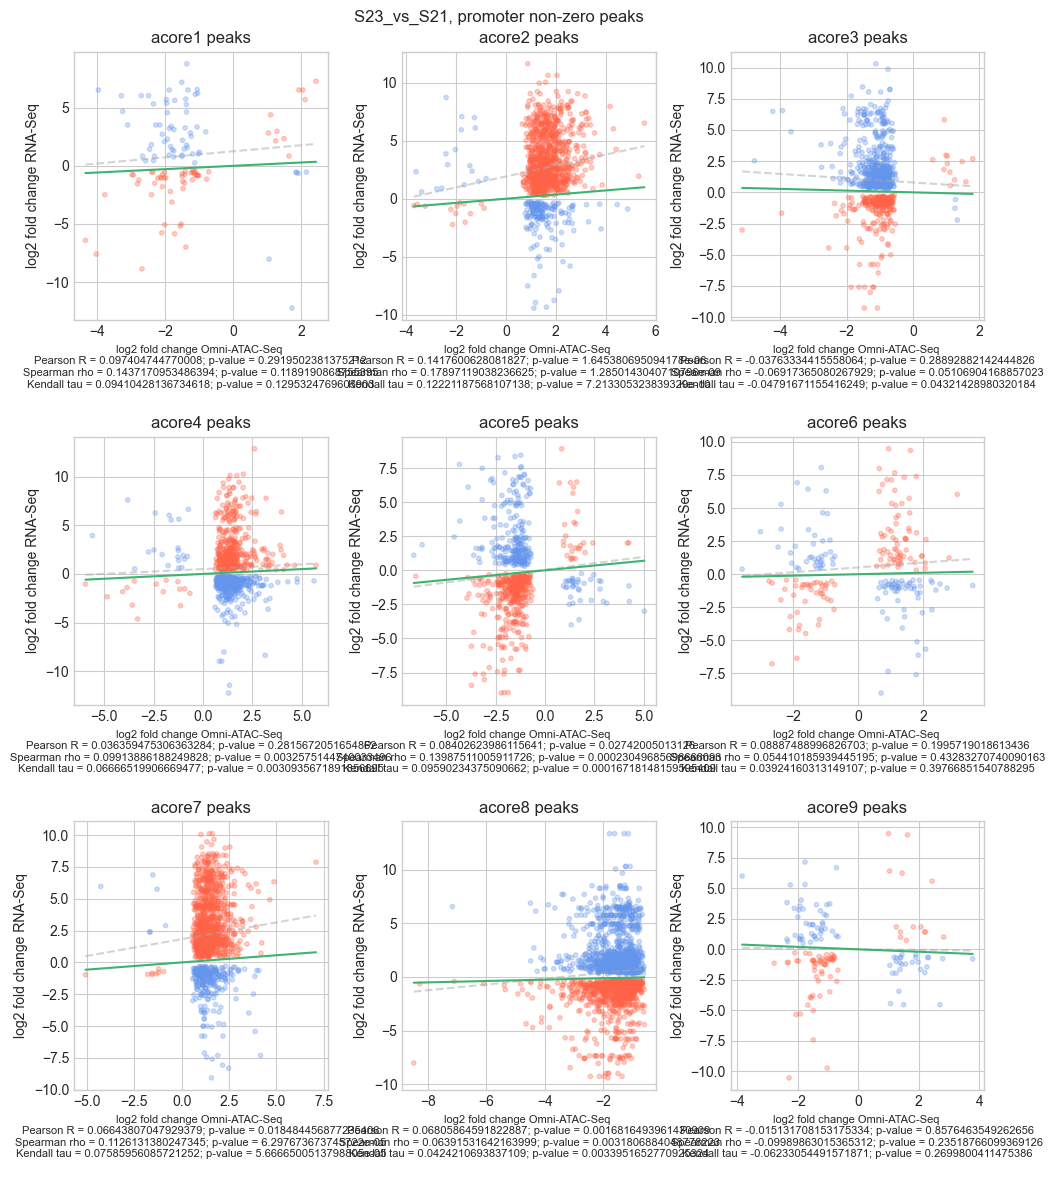

In [16]:
for comparison in versussigclusters:
    
    plt.figure(figsize = (10, 12))
    plt.suptitle(comparison + ', promoter non-zero peaks')
    i = 1
    for acore in np.arange(1, acores + 1):
        dummy = versussigclusters[comparison][versussigclusters[comparison]['best_cluster'] == acore]
        x, y = dummy['log2FoldChange_x'].values, dummy['log2FoldChange_y'].values
        pearson, pearson_p = scipy.stats.pearsonr(x, y)
        spearman, spearman_p = scipy.stats.spearmanr(x, y)
        kendall, kendall_p = scipy.stats.kendalltau(x, y)
        m, b = np.polyfit(x, y, 1)
        
        color = ['tomato' if (x[i] * y[i] > 0) else 'cornflowerblue' for i in np.arange(len(x))]
        
        xrange = np.linspace(min(x), max(x), 500)
        
        plt.subplot(3, 3, i)
        plt.scatter(x = x, y = y, color = color, alpha = 0.3, s = 10)
        plt.plot(xrange, m * xrange + b, linestyle = 'dashed', c = 'darkgray', alpha = 0.5)
        plt.plot(xrange, spearman * xrange, c = 'mediumseagreen')
        plt.title('acore' + str(acore) + ' peaks')
        plt.ylabel('log2 fold change RNA-Seq')
        plt.xlabel('log2 fold change Omni-ATAC-Seq \n' + 
               'Pearson R = ' + str(pearson) + '; p-value = ' + str(pearson_p) + '\n' +
               'Spearman rho = ' + str(spearman) + '; p-value = ' + str(spearman_p) + '\n' + 
               'Kendall tau = ' + str(kendall) + '; p-value = ' + str(kendall_p) + '\n', fontsize = 8)
        i += 1
    plt.tight_layout()
    plt.show()

## 14. Generate a dataframe that serves as a dictionary to convert mikado genes to Drosophila UNIPROT IDs for GO enrichment analysis

In [3]:
columns = ['Orthogroup', 'mikado_gene', 'Drosophila_ID']
assigned = pd.DataFrame(pd.read_csv('~/Labwork/Bioinformatics/Parhyale_RNA-Seq/SLURM_scripts/OrthoFinder_mikado/' + 'Orthogroups.tsv', sep='\t', names = columns, skiprows = 1))
assigned['UNIPROT_ID'] = assigned['Drosophila_ID'].str.split('|', expand = True)[1]

display(assigned)

OGs = []
genes = []
Dro_IDs = []
UNI_IDs = []

assigned_split = assigned[assigned['mikado_gene'].str.contains(',')]
assigned_unsplit = assigned[~assigned['mikado_gene'].str.contains(',')]
assigned_unsplit['mikado_newgene'] = assigned_unsplit['mikado_gene'].apply(lambda x: '.'.join(x.split('.')[0:3]))
assigned_unsplit['mikado_gene'] = assigned_unsplit['mikado_newgene']
assigned_unsplit.drop(columns = ['mikado_newgene'], inplace = True)
display(assigned_split)

for index, row in assigned_split.iterrows():
    OG = row['Orthogroup']
    mikado_genes = row['mikado_gene'].split(', ')
    ID = row['Drosophila_ID']
    UNI_ID = row['UNIPROT_ID']
    for gene in mikado_genes:
        gene_stripped = '.'.join(gene.split('.')[0:3])
        OGs = OGs + [OG]
        genes = genes + [gene_stripped]
        Dro_IDs = Dro_IDs + [ID]
        UNI_IDs = UNI_IDs + [UNI_ID]

new_rows = pd.DataFrame({'Orthogroup': OGs, 'mikado_gene': genes, 'Drosophila_ID': Dro_IDs, 'UNIPROT_ID': UNI_IDs})
all_list = new_rows.append(assigned_unsplit)
all_list.drop_duplicates(inplace = True)

display(all_list)

Orthogroup  \
0     OG0000000   
1     OG0000001   
2     OG0000002   
3     OG0000003   
4     OG0000004   
...         ...   
5977  OG0005977   
5978  OG0005978   
5979  OG0005979   
5980  OG0005980   
5981  OG0005981   

                                                                                              mikado_gene  \
0     mikado.phaw_50.282976aG39.1.p1, mikado.phaw_50.282976aG39.2.p1, mikado.phaw_50.282976aG39.3.p1, ...   
1     mikado.phaw_50.283828bG67.2.p1, mikado.phaw_50.283828bG67.3.p1, mikado.phaw_50.283828bG67.4.p1, ...   
2     mikado.phaw_50.283865cG148.2.p1, mikado.phaw_50.283865cG148.3.p1, mikado.phaw_50.283865cG148.4.p...   
3     mikado.phaw_50.020523aG19.1.p1, mikado.phaw_50.020523aG19.2.p1, mikado.phaw_50.020523aG19.3.p1, ...   
4     mikado.phaw_50.282654bG164.2.p1, mikado.phaw_50.282654bG164.3.p1, mikado.phaw_50.282654bG164.4.p...   
...                                                                                                   ...   
5977                                                                       mikado.phaw_50.283875aG83.2.p1   
5978                                                                       mikado.phaw_50.283875aG85.1.p1   
5979                                                                       mikado.phaw_50.283875aG91.1.p1   
5980                                                                       mikado.phaw_50.283875aG92.1.p1   
5981                                                                       mikado.phaw_50.283875aG96.1.p1   

               Drosophila_ID UNIPROT_ID  
0     tr|Q9V436|Q9V436_DROME     Q9V436  
1     tr|M9PFU5|M9PFU5_DROME     M9PFU5  
2     tr|Q95RP8|Q95RP8_DROME     Q95RP8  
3     tr|Q0E980|Q0E980_DROME     Q0E980  
4       sp|Q9V597|RL31_DROME     Q9V597  
...                      ...        ...  
5977   sp|Q9VAC5|ADA17_DROME     Q9VAC5  
5978  tr|Q9VES0|Q9VES0_DROME     Q9VES0  
5979  tr|Q9W125|Q9W125_DROME     Q9W125  
5980    sp|Q94526|ORK1_DROME     Q94526  
5981  tr|B7YZU4|B7YZU4_DROME     B7YZU4  

[5982 rows x 4 columns]

<ipython-input-3-c9fec670888a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_unsplit['mikado_newgene'] = assigned_unsplit['mikado_gene'].apply(lambda x: '.'.join(x.split('.')[0:3]))
<ipython-input-3-c9fec670888a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_unsplit['mikado_gene'] = assigned_unsplit['mikado_newgene']
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

Orthogroup  \
0    OG0000000   
1    OG0000001   
2    OG0000002   
3    OG0000003   
4    OG0000004   
..         ...   
562  OG0000562   
563  OG0000563   
564  OG0000564   
565  OG0000565   
566  OG0000566   

                                                                                             mikado_gene  \
0    mikado.phaw_50.282976aG39.1.p1, mikado.phaw_50.282976aG39.2.p1, mikado.phaw_50.282976aG39.3.p1, ...   
1    mikado.phaw_50.283828bG67.2.p1, mikado.phaw_50.283828bG67.3.p1, mikado.phaw_50.283828bG67.4.p1, ...   
2    mikado.phaw_50.283865cG148.2.p1, mikado.phaw_50.283865cG148.3.p1, mikado.phaw_50.283865cG148.4.p...   
3    mikado.phaw_50.020523aG19.1.p1, mikado.phaw_50.020523aG19.2.p1, mikado.phaw_50.020523aG19.3.p1, ...   
4    mikado.phaw_50.282654bG164.2.p1, mikado.phaw_50.282654bG164.3.p1, mikado.phaw_50.282654bG164.4.p...   
..                                                                                                   ...   
562                                       mikado.phaw_50.283875aG25.1.p1, mikado.phaw_50.283875aG25.2.p1   
563                                     mikado.phaw_50.283875aG367.1.p1, mikado.phaw_50.283875aG367.2.p1   
564                                     mikado.phaw_50.283875aG407.1.p1, mikado.phaw_50.283875aG407.3.p1   
565                                     mikado.phaw_50.283875aG409.1.p1, mikado.phaw_50.283875aG410.1.p1   
566                                     mikado.phaw_50.283875aG530.1.p1, mikado.phaw_50.283875aG530.2.p1   

              Drosophila_ID UNIPROT_ID  
0    tr|Q9V436|Q9V436_DROME     Q9V436  
1    tr|M9PFU5|M9PFU5_DROME     M9PFU5  
2    tr|Q95RP8|Q95RP8_DROME     Q95RP8  
3    tr|Q0E980|Q0E980_DROME     Q0E980  
4      sp|Q9V597|RL31_DROME     Q9V597  
..                      ...        ...  
562  tr|Q8SXF0|Q8SXF0_DROME     Q8SXF0  
563    sp|Q9VKB4|RPF1_DROME     Q9VKB4  
564   sp|Q960X4|TIP60_DROME     Q960X4  
565     sp|Q95028|LDH_DROME     Q95028  
566  tr|Q8IQI3|Q8IQI3_DROME     Q8IQI3  

[554 rows x 4 columns]

Orthogroup                 mikado_gene           Drosophila_ID UNIPROT_ID
0     OG0000000   mikado.phaw_50.282976aG39  tr|Q9V436|Q9V436_DROME     Q9V436
7     OG0000001   mikado.phaw_50.283828bG67  tr|M9PFU5|M9PFU5_DROME     M9PFU5
12    OG0000002  mikado.phaw_50.283865cG148  tr|Q95RP8|Q95RP8_DROME     Q95RP8
17    OG0000003   mikado.phaw_50.020523aG19  tr|Q0E980|Q0E980_DROME     Q0E980
21    OG0000004  mikado.phaw_50.282654bG164    sp|Q9V597|RL31_DROME     Q9V597
...         ...                         ...                     ...        ...
5977  OG0005977   mikado.phaw_50.283875aG83   sp|Q9VAC5|ADA17_DROME     Q9VAC5
5978  OG0005978   mikado.phaw_50.283875aG85  tr|Q9VES0|Q9VES0_DROME     Q9VES0
5979  OG0005979   mikado.phaw_50.283875aG91  tr|Q9W125|Q9W125_DROME     Q9W125
5980  OG0005980   mikado.phaw_50.283875aG92    sp|Q94526|ORK1_DROME     Q94526
5981  OG0005981   mikado.phaw_50.283875aG96  tr|B7YZU4|B7YZU4_DROME     B7YZU4

[6010 rows x 4 columns]

## 15. Generate list of genes in concordant vs. discordant groups for each timepoint comparison

In [ ]:
make_gene_lists = True
comparisons = ['S19_vs_S13', 'S21_vs_S19', 'S23_vs_S21']

for comparison in comparisons:
    dummydf = significantdfs[comparison]
    
    genelist_dict = {}
    peaks = dummydf.merge(all_list, left_on = 9, right_on = 'mikado_gene', how = 'left')
    concordant_genes = peaks[peaks['log2FoldChange_x'] * peaks['log2FoldChange_y'] > 0]
    genelist_dict['CC_peak'] = concordant_genes['UNIPROT_ID'].unique()
    discordant_genes = peaks[peaks['log2FoldChange_x'] * peaks['log2FoldChange_y'] < 0]
    genelist_dict['DC_peak'] = discordant_genes['UNIPROT_ID'].unique()
    
    pros = dummydf[dummydf[1] == 'promoter'].merge(all_list, left_on = 9, right_on = 'mikado_gene', how = 'left')
    concordant_pro_genes = pros[pros['log2FoldChange_x'] * pros['log2FoldChange_y'] > 0]
    genelist_dict['CC_pro'] = concordant_pro_genes['UNIPROT_ID'].unique()
    discordant_pro_genes = pros[pros['log2FoldChange_x'] * peaks['log2FoldChange_y'] < 0]
    genelist_dict['DC_pro'] = discordant_pro_genes['UNIPROT_ID'].unique()
    
    for genelist in genelist_dict:
        if make_gene_lists:
            with open('Omni_vs_RNA_' + comparison + '_' + genelist + '.txt', 'w+') as f:
                for item in genelist_dict[genelist]:
                    f.write("%s\n" % item)

## 16. Convert GO enrichment analysis for concordant/discordant peaks into bar charts

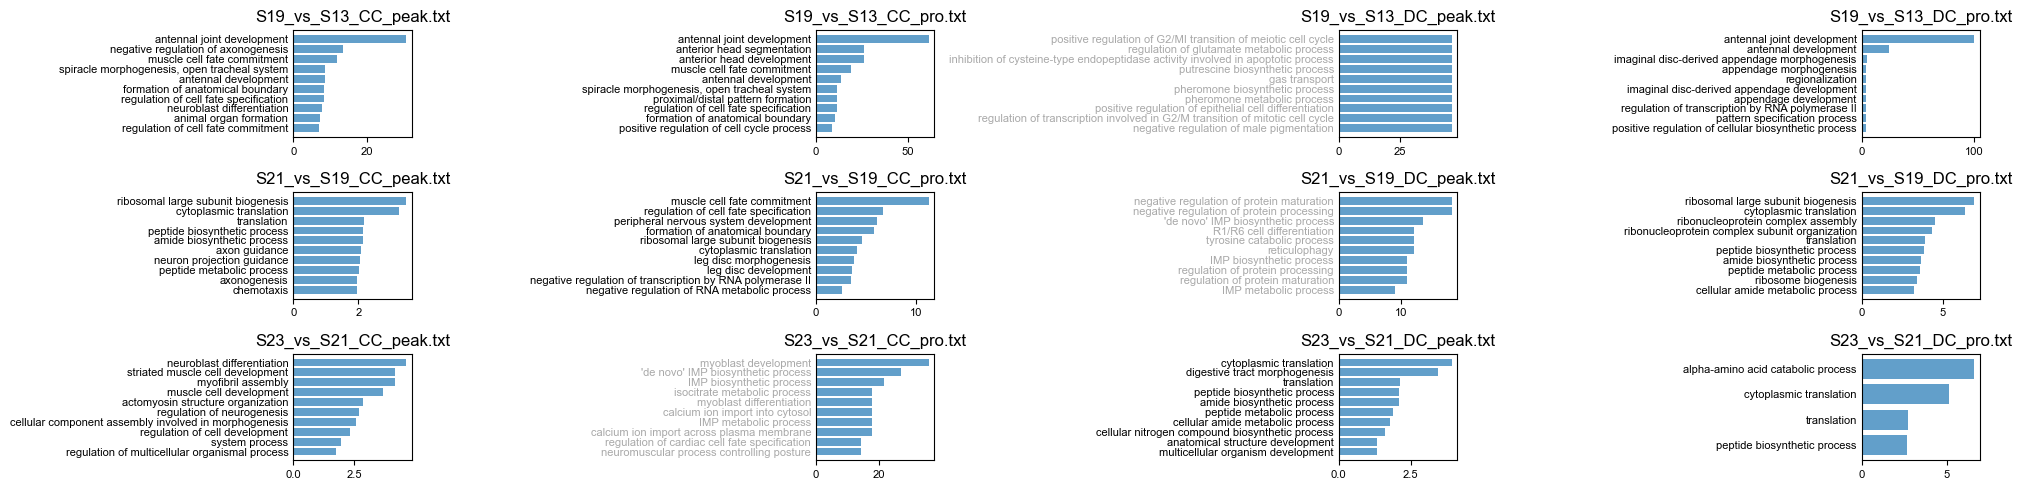

In [7]:
GOterm_filename_list = sorted(glob.glob('GO_Omni_vs_RNA_*'))
n = 10

fields = ['GO biological process complete', 'reflist', 'input', 'expected', 'over/under', 'fold Enrichment', 'p-value', 'FDR']

plt.figure(figsize = (20, 5))

i = 1
for filename in GOterm_filename_list:
    GOterms = pd.DataFrame(pd.read_csv(filename, skiprows = 7,sep = '\t', names = fields))
    GOterms = GOterms[GOterms['fold Enrichment'] != ' < 0.01']
    GOterms.replace({' > 100': '100'}, regex = True, inplace = True)
    GOterms['fold Enrichment'] = GOterms['fold Enrichment'].astype('float')
    GOterms.sort_values('fold Enrichment', ascending = False, inplace = True)
    topn = GOterms.head(n)
    
    trigger = False
    
    if sum(topn['FDR']) == n:
        trigger = True
        topn_temp = GOterms[GOterms['p-value'] < 0.05]
        topn = topn_temp.sort_values('fold Enrichment', ascending = False).head(n)
    
    hatchvalue = "//" if trigger else None
    
    plt.subplot(3, 4, i)
    names = [k.split(' (')[0] for k in topn['GO biological process complete']]
    plt.barh(names, topn['fold Enrichment'], alpha = 0.7)
    if trigger:
        plt.tick_params(axis='y', colors='darkgrey')
    plt.tick_params(axis='y', which='both', length=0)
    plt.gca().invert_yaxis()
    plt.yticks(fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.title(filename.replace('GO_Omni_vs_RNA_', ''))
    
    i += 1
    
plt.tight_layout()

plt.savefig('Omni_vs_RNA_GO_CCDC_lists.svg')

plt.show()

## 17. Convert GO enrichment analysis for acccessibility vs. expression into bar charts

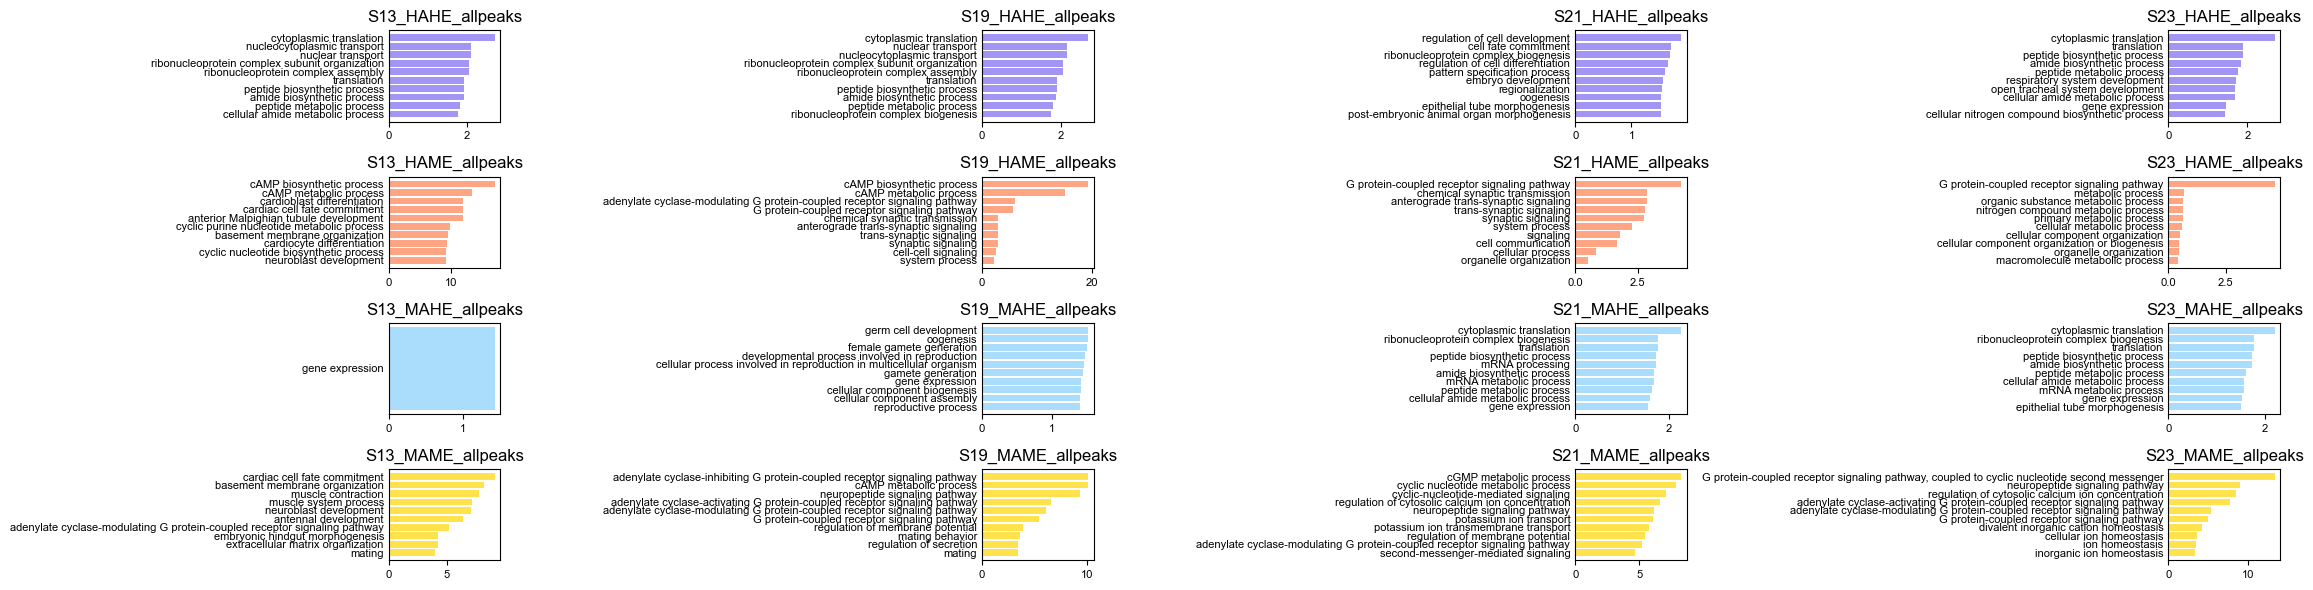

In [38]:
GOterm_filename_list = sorted(glob.glob('OmnivsRNAlists/all_peaks/GO_OmnivsRNA_*'))
n = 10

fields = ['GO biological process complete', 'reflist', 'input', 'expected', 'over/under', 'fold Enrichment', 'p-value', 'FDR']

plt.figure(figsize = (23, 6))
plt_order = [1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15, 4, 8, 12, 16]

listvscolordict = {'HAHE':'mediumslateblue',
                   'HAME':'coral',
                   'MAHE':'lightskyblue',
                   'MAME':'gold'}

i = 1
for filename in GOterm_filename_list:
    GOterms = pd.DataFrame(pd.read_csv(filename, skiprows = 7,sep = '\t', names = fields))
    GOterms = GOterms[GOterms['fold Enrichment'] != ' < 0.01']
    GOterms.replace({' > 100': '100'}, regex = True, inplace = True)
    GOterms['fold Enrichment'] = GOterms['fold Enrichment'].astype('float')
    GOterms.sort_values('fold Enrichment', ascending = False, inplace = True)
    topn = GOterms.head(n)
    
    abbrev = filename.replace('OmnivsRNAlists/all_peaks/GO_OmnivsRNA_', '').replace('.txt', '')
    
    trigger = False

    if sum(topn['FDR']) == n:
        trigger = True
        topn_temp = GOterms[GOterms['p-value'] < 0.05]
        topn = topn_temp.sort_values('fold Enrichment', ascending = False).head(n)
    
    plt.subplot(4, 4, plt_order[i - 1])
    names = [k.split(' (')[0] for k in topn['GO biological process complete']]
    
    barcolor = listvscolordict[abbrev.split('_')[1]]
    
    plt.barh(names, topn['fold Enrichment'], alpha = 0.7, color = barcolor)
    if trigger:
        plt.tick_params(axis='y', colors='darkgrey')
    plt.tick_params(axis='y', which='both', length=0)
    plt.gca().invert_yaxis()
    plt.yticks(fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.title(abbrev)
    
    i += 1
    
plt.tight_layout()

plt.savefig('OmnivsRNA_AE_lists.svg')

plt.show()